# Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [1]:
in_colab = True;
try:
  from google.colab import drive
  mount_location = '/content/drive'
  drive.mount(mount_location,force_remount=True);
  
  from pathlib import Path
  import sys
  libraries_path =  "MyDrive" #@param {type:"string"}
  colab_libraries_path = Path(mount_location)/libraries_path
  print("c_libraries_path:",colab_libraries_path)
  sys.path.insert(0,str(colab_libraries_path)); #add google drive's libraries to path
  
  from google.colab import auth
  #This allows SDK to see and edit Google Drive files
  #SDK is required to interact with GCP
  auth.authenticate_user()
except ImportError as ie:
  print("google not found; assuming non-colab execution")
  print(ie);
  in_colab = False;
except Exception as e:
  print("google authentication failed, please retry")
  raise e



google not found; assuming non-colab execution
No module named 'google'


# Global Parameters and Setup


## General library imports

In [2]:
try:
    %pip install -r requirements.txt
except:
    %pip install -Uqq scikit-image
    %pip install -Uqq tifffile
    %pip install Pillow==9.0.1
    %pip install scikit-image==0.19.3
    %pip install -Uqq mediapy

try:
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
except:
    pass


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip
The system cannot find the path specified.
'apt' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
from __future__ import annotations
import numpy as np
from ipywidgets import interact, widgets, Layout
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imsave, imshow
from skimage import data, filters, measure, morphology, util
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from skimage.measure import  regionprops, regionprops_table
from pathlib import Path
from fastprogress.fastprogress import progress_bar,master_bar
from enum import Enum
import tifffile
import pandas as pd
import cv2
import ntpath
import os
import stat
import time
import pickle
import re
import copy
import scipy
import builtins
import shutil
import contextlib
import zipfile
from itertools import starmap
from functools import partial
import random
import csv
from scipy import ndimage
from scipy.stats import skew
import numpy as np
from ipywidgets import interact, widgets, Layout
from IPython.utils.io import capture_output
import matplotlib.pyplot as plt
from typing import Dict, DefaultDict, Tuple, List, Union, Iterable

import itertools
import math

import mediapy as media

from operator import itemgetter

## THESE ARE NOT USEFUL: just to allow reloading
import libraries.filter_cells_fns
import libraries.centers
import libraries.qc_functions
import libraries.centroidtracker
import libraries.smoothing
import libraries.parsend
import libraries.analysis
import libraries.parse_moviefolder

#Get from Drive the folder libraries
def load_libraries():
    import importlib
    [importlib.reload(f) for f in [libraries.filter_cells_fns,
                                   libraries.centers,
                                   libraries.qc_functions,
                                   libraries.centroidtracker,
                                   libraries.smoothing,
                                   libraries.parsend,
                                   libraries.analysis,
                                   libraries.parse_moviefolder]]
        
    from libraries.filter_cells_fns import remove_multiple_nuclei_cells, remove_large_objects, remove_touching_edge
    from libraries.centers import get_centers, fill_label_holes, normalize
    from libraries.qc_functions import apply_qc
    from libraries.centroidtracker import CentroidTracker
    from libraries.smoothing import moving_average
    from libraries.parsend import parseND, StageDict, group_stage_basenames
    from libraries.analysis import scale_tracks,analyze_experiment_tracks,save_tracks_analysis_csv
    from libraries.parse_moviefolder import get_movie_params
    
    globals().update(locals())
load_libraries()


## Auxiliary Helper Functions

### GCP Path formatting

In [4]:
def is_gcp_path(path:Union[str,Path]):
  if not isinstance(path,Path):
    path = Path(path);
  return path.parts[0].lower() == "gs:";

### File zipping/unzipping

In [22]:
def _linux_cmd_zip(source,dest,recurse=False,compresslevel:Union[int,None]=None,bar=None,relative_to = ""):
    relative = Path(source)/relative_to
    dest = Path(dest)
    if compresslevel is not None:
        compresstext = f"-{compresslevel}"
        if recurse:
            result = !cd "{relative}" && zip "{compresstext}" -r "{dest.name}" *
        else:
            result = !cd "{relative}" && zip "{compresstext}" "{dest.name}" *
    else:
        if recurse:
            result = !cd "{relative}" && zip -r "{dest.name}" *
        else:
            result = !cd "{relative}" && zip "{dest.name}" *
    shutil.move(relative/dest.name,dest);
    return result

def _python_cmd_zip(source,dest,recurse=False,compresslevel:Union[int,None]=6,bar=False,relative_to = ""):
    print(source);
    if compresslevel is None:
        compresslevel = 6
    source = Path(source);
    relative = source/relative_to
    dest = Path(dest)
    paths = list((source.rglob("*") if recurse else source.iterdir()))
    if paths:
        paths = progress_bar(paths)
    with zipfile.ZipFile(dest,'w',compression=zipfile.ZIP_DEFLATED,compresslevel=compresslevel) as archive:
        for filepath in paths:
            archive.write(filepath,arcname=filepath.relative_to(source));
zipExists = shutil.which("zip")
cmd_zip = _linux_cmd_zip if zipExists else _python_cmd_zip
print("using python zip" if not zipExists else "using cmdline zip")

def _linux_cmd_unzip(source,dest,overwrite=False)->List[str]:
  flags = "-" + ("o" if overwrite else "")
  if flags ==  "-":
    result = !unzip "{source}" -d "{dest}" 
  else:
    result = !unzip "{flags}" "{source}" -d "{dest}" 
  return result

def _python_cmd_unzip(source,dest,overwrite=False):
    source = Path(source);
    dest = Path(dest);
    with zipfile.ZipFile(source,'r') as archive:
        for member in archive.infolist():
            file_path = dest/member.filename
            if not file_path.exists():
                archive.extract(member, dest)

unzipExists = shutil.which("unzip")
cmd_unzip = _linux_cmd_unzip if unzipExists else _python_cmd_unzip
print("using python unzip" if not unzipExists else "using cmdline unzip")

using cmdline zip
using python unzip


### Gsutil String Handling

In [6]:
def gs_str(p:Union[str,Path]):
    p = Path(p);
    out = ""
    if is_gcp_path(p):
        p = Path(*p.parts[1:])
        out = "gs://"
    out += p.as_posix();
    return out

### Path Formatting

In [7]:
class SafeDict(dict):
    def __missing__(self, key):
        return '{' + key + '}'

    
suffix_regex = ' \\${0}'
def strsuffix(exp:str,suffixes=None):
    if isinstance(suffixes,str):
        suffixes = [suffixes]
    elif not isinstance(suffixes,Iterable):
        suffixes = ["\\S*"]
    for suffix in suffixes:
        r = suffix_regex.format(suffix)
        exp = re.sub(r,'',exp)
    return exp
    

def format_path(path:Union[str,Path],
                collection:Union[bool,None]=None,
                movie:Union[int,None]=None,
                experiment:Union[str,None]=None,
                qc_params:Union[Dict[str,Any],None]=None,
                strip_suffix:Union[bool,list[str]]=False,
                **kwargs):
    is_path = isinstance(path,Path);
    path = str(path);
    map = SafeDict();
    if collection is not None:
        map["collection"] = "using" if collection else "no";
    if movie is not None:
        map["movie"] = str(movie);
    if experiment is not None:
        map["experiment_nostrip"] = experiment
        if strip_suffix:
            experiment = strsuffix(experiment,strip_suffix);
        map["experiment"] = experiment;
    if qc_params is not None:
        map["smoothing"] = [['raw','smoothed'],
                             ['spaced','spaced_smoothed']][qc_params.get("do_spacing",False)][qc_params.get("do_smoothing",False)];

    map.update(kwargs);
    result = path.format_map(map);
    if is_path:
        result = Path(result);
    return result;
  

## Input Paths and Settings

### Colab Parameters

In [8]:
#@markdown where various folders are on disk, you probably never need to change these

local_folder = "content" #@param {type:"string"};
local_folder:Path = Path(local_folder);

#@markdown local folder where files and folders are stored when downloaded from GCP
gcp_transfer_folder = "gcp_transfer" #@param {type:"string"}
gcp_transfer_folder:Path = Path(gcp_transfer_folder)

#@markdown local folder where files and folders are stored locally that should be cleared between operations
temp_folder = "temp" #@param {type:"string"}
temp_folder:Path = Path(temp_folder)

if not os.path.exists(gcp_transfer_folder):
  os.mkdir(gcp_transfer_folder);

if not os.path.exists(temp_folder):
  os.mkdir(temp_folder);

### Experimental Parameters

In [9]:
#@markdown Experiment Name (will be incorporated into output file and folder names)
#@markdown Suffixes: if you append an experiment name with " $[suffix]", path formatting (with the exception of segmentation analysis) will use the experiment stripped of *suffix
experiment = "2023.06.07" #@param {type:"string"}

#@markdown Analysis folder: all output analysis data will be output to {analysis output folder}/{experiment name}. Include gs:// to place in the bucket
analysis_output_folder = "gs://optotaxisbucket/Matt Segmentation Analysis" #@param {type:"string"}
analysis_output_folder:Path = Path(analysis_output_folder)
gcp_analysis_output_folder:Path = analysis_output_folder/experiment if is_gcp_path(analysis_output_folder) else None;
local_analysis_output_folder:Path = gcp_transfer_folder/analysis_output_folder.name/experiment;
del analysis_output_folder;

if "images_source" in locals():
    prev_im = images_source
else:
    prev_im = None;

if "cellmasks_source" in locals():
    prev_cm = cellmasks_source
else:
    prev_cm = None;

if "nucmasks_source" in locals():
    prev_nm = nucmasks_source
else:
    prev_nm = None;

#@markdown For any of the following paths, if you put {experiment} in the string, it'll replace that with the name of the experiment for convenience:

#@markdown Location of experiment images. Can be a folder, a .zip file, or a tif stack; If a zip file, should contain a folder of the same name as the zip file. Include 'gs://' to pull from the a google cloud storage bucket
# optotaxisbucket/matt_movies/2023.06.07/images
images_source_s:str = "gs://optotaxisbucket/matt_movies/{experiment}/images" #@param {type:"string"}
images_source:Path = Path(format_path(images_source_s,experiment=experiment,strip_suffix=True))

#@markdown Location of segmented cell-area masks. Can be a folder, a .zip file, or a tif stack; If a zip file, should contain a folder of the same name as the zip file. Include 'gs://' to pull from the a google cloud storage bucket
cellmasks_source_s:str = "gs://optotaxisbucket/matt_movie_segmentation/{experiment}/masks/Cell.zip" #@param {type:"string"}
cellmasks_source:Path = Path(format_path(cellmasks_source_s,experiment=experiment,strip_suffix=True));

#@markdown Location of segmented nucleus-area masks. Can be a folder, a .zip file, or a tif stack; If a zip file, should contain a folder of the same name as the zip file. Include 'gs://' to pull from the a google cloud storage bucket
nucmasks_source_s = "gs://optotaxisbucket/matt_movie_segmentation/{experiment}/masks/Cell.zip" #@param {type:"string"}
nucmasks_source:Path = Path(format_path(nucmasks_source_s,experiment=experiment,strip_suffix=True));


images_changed,cell_masks_changed,nuc_masks_changed = [False,False,False];
if images_source != prev_im:
    images_changed = True;
if cellmasks_source != prev_cm:
    cell_masks_changed = True;
if nucmasks_source != prev_nm:
    nuc_masks_changed = True;

parameters_updated = True


for test,name in progress_bar([(images_source,"Images"),(cellmasks_source,"Cell masks"),(nucmasks_source,"Nucleus masks")]):
    print(f"Testing {name}...")
    if is_gcp_path(test):
        test = gs_str(test);
        if (not str(test).lower().endswith((".zip",".tif",".tiff"))): #directory
            test = test + '/*'
        valid = os.system(f"gsutil -q stat \"{test}\"");
        if (valid != 0): #test location does not exist
            raise Exception(f"Error: {name} dir {test} does not exist in bucket. To ignore this error simply run the succeeding cells.")
    else:
        if not os.path.exists(test):
            raise Exception(f"Error: {name} dir {test} does not exist on local machine. To ignore this error simply run the succeeding cells.")
    print(f"{name} folder verified: {test}")

print("Successfully verified inputs - all folders and files exist in the bucket")

Testing Images...
Images folder verified: gs://optotaxisbucket/movies/2023.3.24 OptoTiam Exp 50/2023.3.24 OptoTiam Exp 50/*
Testing Cell masks...
Cell masks folder verified: gs://optotaxisbucket/movie_segmentation/2023.3.24 OptoTiam Exp 50/segmentation_output_masks/Cell.zip
Testing Nucleus masks...
Nucleus masks folder verified: gs://optotaxisbucket/movie_segmentation/2023.3.24 OptoTiam Exp 50/segmentation_output_masks/Nucleus.zip
Successfully verified inputs - all folders and files exist in the bucket


### Analysis Output Filenames


In [10]:
#@markdown ## The names/locations of various parameter and analysis output files within the segmentation analysis folder
#@markdown ### All input paths are relative to the analysis output folder defined in the previous cell

if not os.path.exists(local_analysis_output_folder):
    os.makedirs(local_analysis_output_folder);
    

movies_folder = local_analysis_output_folder/"Output Movies" #@param

#@markdown #### Analysis Parameters
parameters_folder = local_analysis_output_folder/"Analysis Parameters" #@param
if not os.path.exists(parameters_folder):
  os.mkdir(parameters_folder)
cell_reading_params_path = parameters_folder/"reading_cells_parameters.pkl" #@param 
track_params_path = parameters_folder/"tracking_parameters.pkl" #@param
metrics_params_path = parameters_folder/"cellmetrics_parameters.pkl"
qc_params_path = parameters_folder/"track_qc_output.pkl" #@param
qc_log_path = parameters_folder/"qc_log.txt"
#make sure no dependency chains
del parameters_folder

#@markdown Analysis Outputs
labeled_cellmasks_path = local_analysis_output_folder/"labeledmasks.zip" #@param
labeled_nucmasks_path = local_analysis_output_folder/"labelednucs.zip" #@param
cell_features_path = local_analysis_output_folder/"cell_features.csv" #@param
raw_tracks_path = local_analysis_output_folder/"tracks.pkl" #@param
qc_tracks_path = local_analysis_output_folder/"qc_tracks.pkl" #@param

parameters_updated = False


## Global helper function setup

### File Management

#### Image Files

In [11]:
#keyword should be unique for each type of object pulled from the cloud to avoid collisions
def _fetch_image_files(in_path:Path,keyword:str,overwrite:bool,capture:bool)->Path: ##should not be called outside of other helper functions, will always overwrite
  if parameters_updated:
    raise Exception("experimental parameters (file paths, exp name, etc) changed without update analysis outputs. Please run Analysis Output Filenames cell!")
  ctx = contextlib.nullcontext if not capture else capture_output;
  is_file = str(in_path).lower().endswith(('.zip','.tif','.tiff'));
  is_gcp = is_gcp_path(in_path);
  destination = gcp_transfer_folder/keyword/strsuffix(experiment);
  if not(os.path.exists(destination)):
    os.makedirs(destination);
  command_output = None;
  if is_gcp and (overwrite or len(os.listdir(destination)) == 0):
    with ctx():
      if is_file:
        command_output = !gsutil -m cp -r "{gs_str(in_path)}" "{gs_str(destination)}"
      else:
        command_output = !gsutil -m rsync -r "{gs_str(in_path)}" "{gs_str(destination)}"
    if (command_output is not None and command_output[0].startswith("CommandException")):
      raise RuntimeError(f"Error while downloading {keyword} from bucket: " + '\n'.join(command_output));
    elif len(os.listdir(destination)) == 0:
      raise RuntimeError("Error: downloading failed for an unknown reason; downloading command_output:",command_output);
  if (not is_file):
    return destination if is_gcp else in_path; #we're done
  else:
    destination = destination/in_path.name;
  if (in_path.suffix == '.zip'):
    out_path = destination.with_suffix('');
    # print(copy_out);
    command_output = None;
    if (overwrite or not os.path.exists(out_path)):
      with ctx():
        command_output = cmd_unzip(destination,destination.parent,overwrite=True)
    # print(command_output);
    if (command_output is not None and command_output[0].startswith("CommandException")):
      raise RuntimeError(f"Error while unzipping {keyword}: " + '\n'.join(command_output));
    elif not os.path.exists(out_path):
      raise RuntimeError(f"Error: zip file {destination} does not contain folder {destination.with_suffix('')}");
    return out_path;
  elif (in_path.suffix.lower().startswith('.tif')):
    raise NotImplementedError("unstacking TIF files not yet supported");
  else:
    raise NameError("Invalid input suffix, input validation should have caught this >:(");  

In [12]:
def fetch_images(force_overwrite=False,capture=False)->Path:
  global images_changed;
  out = _fetch_image_files(Path(images_source),'images',images_changed or force_overwrite,capture);
  images_changed = False;
  return out;

def fetch_cell_masks(force_overwrite=False,capture=False)->Path:
  global cell_masks_changed;
  out = _fetch_image_files(Path(cellmasks_source),'cellmasks',cell_masks_changed or force_overwrite,capture);
  cell_masks_changed = False;
  return out;

def fetch_nuc_masks(force_overwrite=False,capture=False)->Path:
  global nuc_masks_changed;
  out = _fetch_image_files(Path(nucmasks_source),'nucmasks',nuc_masks_changed or force_overwrite,capture);
  nuc_masks_changed = False;
  return out;

#### Analysis Files

In [13]:
def push_analysis(): #VERY IMPORTANT: THIS METHOD RELIES ON local_analysis_output_folder BEING ONE-DEPTH
  '''Push to sync the current contents of the gcp bucket's gcp_analysis_output_folder with its local counterpart'''
  if parameters_updated:
    raise Exception("experimental parameters (file paths, exp name, etc) changed without update analysis outputs. Please run Analysis Output Filenames cell!")
  if gcp_analysis_output_folder is None:
    print("Segmentation analysis is local only; skipping push");
    return;
  s = !gsutil -m rsync -r "{gs_str(local_analysis_output_folder)}" "{gs_str(gcp_analysis_output_folder)}"
  if (s[0].startswith("CommandException")):
    raise RuntimeError("error while uploading analysis folder: " + '\n'.join(s));

def fetch_analysis():
  '''Pull to sync the current contents of local_analysis_output_folder with its counterpart in the gcp bucket'''
  if parameters_updated:
    raise Exception("experimental parameters (file paths, exp name, etc) changed without update analysis outputs. Please run Analysis Output Filenames cell!")
  if gcp_analysis_output_folder is None:
    print("Segmentation analysis is local only; skipping fetch");
    return;
  if not os.path.exists(local_analysis_output_folder):
    os.makedirs(local_analysis_output_folder);
  t = !gsutil ls "{gs_str(gcp_analysis_output_folder)}"
  if (t[0].startswith("CommandException")):
    print("analysis folder not found in bucket, skipping analysis fetch:");
    print('\n'.join(t));
    return;
  s = !gsutil -m rsync -r "{gs_str(gcp_analysis_output_folder)}" "{gs_str(local_analysis_output_folder)}"
  if (s[0].startswith("CommandException")):
    raise RuntimeError("error while downloading analysis folder: " + '\n'.join(s));

In [14]:
def _submit_masks(source:Path,dest:Path):
  cmd_zip(source,dest,recurse=True);
  push_analysis()

def submit_labeled_cellmasks(submission:Path):
  '''Input a folder containing a list of cell masks; will zip, put into analysis, and push'''
  return _submit_masks(submission,labeled_cellmasks_path)

def submit_labeled_nucmasks(submission:Path):
  '''Input a folder containing a list of nucleus masks; will zip, put into analysis, and push'''
  return _submit_masks(submission,labeled_nucmasks_path);

def _fetch_masks(file:Path): #THIS NEEDS TO BE TESTED!!!!!!!!!
  fetch_analysis()
  dest = temp_folder/(file.stem)
  cmd_unzip(file,dest,overwrite=True);
  return dest

def fetch_labeled_cellmasks():
  '''Pulls and unzips labeled and filtered cell masks from segmentation analysis; returns a folder containing the masks'''
  return _fetch_masks(Path(labeled_cellmasks_path));

def fetch_labeled_nucmasks():
  '''Pulls and unzips labeled and filtered nucleus masks from segmentation analysis; returns a folder containing the masks'''
  return _fetch_masks(Path(labeled_nucmasks_path));

#### Misc

In [15]:
def on_rm_error( func, path, exc_info):
    # path contains the path of the file that couldn't be removed
    # let's just assume that it's read-only and unlink it.
    os.chmod( path, stat.S_IWRITE )
    # os.unlink( path )

def cleardir(dir): #clears all files in dir without deleting dir
  for f in os.scandir(dir):
    # f = os.path.join(dir,f)
    if os.path.isdir(f): shutil.rmtree(f,onerror=on_rm_error); #just in case
    else: os.remove(f);

### Cell filtering

In [16]:
def getcells(filecell:Union[Union[str, bytes, os.PathLike],np.ndarray],filenuc:Union[Union[str, bytes, os.PathLike],np.ndarray],parameters,return_metrics=False,centertype="approximate-medoid",all_centers=False):
  #membrane
  maskMem:np.ndarray=imread(filecell) if not isinstance(filecell,np.ndarray) else filecell;
  # print(np.min(maskmem));
  # print(np.max(maskmem));
  maskMem[maskMem>0]=1
  #fill holes
  maskMem=ndimage.binary_fill_holes(maskMem).astype(int);

  #nuclei
  maskNuc:np.ndarray = imread(filenuc) if not isinstance(filenuc,np.ndarray) else filenuc;
  maskNuc[maskNuc>0]=1

  #label different objectes in masks
  maskMem,numMem = measure.label(maskMem,return_num=True)
  maskNuc,numNuc = measure.label(maskNuc,return_num=True);

  if numMem < 255 and numNuc < 255:
    maskMem = maskMem.astype('uint8');
    maskNuc = maskNuc.astype('uint8');
  else:
    maskMem = maskMem.astype('uint16');
    maskNuc = maskNuc.astype('uint16');
  
  #FILTERS
  if parameters['remove_cells_touching_edge'] == True:
    maskMem=remove_touching_edge(maskMem)
  
  if parameters['filter_cell_size'] == True:
    maskMem = morphology.remove_small_objects(maskMem, parameters['minareacell'])       
    maskMem = remove_large_objects(maskMem, parameters['maxareacell'])
  
  if parameters['filter_nuc_size'] == True:
    maskNuc = morphology.remove_small_objects(maskNuc, parameters['minareanuc'])       
  
  if parameters['remove_multi_nuclei_cells'] == True:
    maskMem = remove_multiple_nuclei_cells(maskMem,maskNuc)

  if (return_metrics):
    #if there are cells get metrics
    ids=list(range(1,numMem+1));
    #remove 0 (background) from ids
    # ids.remove(0)
    if len(ids) > 0:
        cellsmetrics = measure.regionprops_table(maskMem, properties=('label','area'))
        cellsmetrics=pd.DataFrame(cellsmetrics)
        if (len(cellsmetrics['label']) > 0 and len(cellsmetrics['area']) > 0):
            #GET CENTERS
            #get labels
            labels=cellsmetrics['label']    
            #Because 'label' was copied from the table, after computing the centers 
            #and concatenating them to the table they should be in the right order
            if not all_centers:
                centers=get_centers(maskMem,centertype,labels, False)
                #add centers to cell properties
                cntr=pd.DataFrame(data=np.asarray(centers),columns=[centertype+'x',centertype+'y'])
                cellsmetrics=pd.concat([cellsmetrics,cntr],axis=1)
            else:
                for ctype in get_centers.valid_centers: 
                    ## to save on import complexity, I (H) just set get_centers.valid_centers to the list of valid center inputs. 
                    ## It's still a function, it just has the attribute now. source is libraries.centers
                    centers=get_centers(maskMem,ctype,labels,False)
                    #add centers to cell properties
                    cntr=pd.DataFrame(data=np.asarray(centers),columns=[centertype+'x',centertype+'y'])
                    cellsmetrics=pd.concat([cellsmetrics,cntr],axis=1)
        
        # centers=get_centers(maskMem,'centroid',labels, False)
        # #add centers to cell properties
        # centroid=pd.DataFrame(data=np.asarray(centers),columns=['centroidx','centroidy'])
        # cellsmetrics=pd.concat([cellsmetrics,centroid],axis=1)
      
        


    else:
      cellsmetrics=pd.DataFrame();
    return cellsmetrics, maskMem, maskNuc 
  else:
    return maskMem,maskNuc
 

# Input Movie Reading Parameters

### Copy images and masks from GCP to Colab (May take some time, zip folders in GCP to speed this up)

In [17]:
from IPython.display import clear_output
folderimages = fetch_images();
foldermasks = fetch_cell_masks();
try:
    foldernucmasks = fetch_nuc_masks();
except Exception as e:
    foldernucmasks = None;
    raise Exception("Warning: nucleus masks not found. If you wish to visualize anyway, keep running cells in Segmentation quality control, but cell filtering will be disabled and settings will not save") from e;
clear_output();

In [18]:
fetch_analysis();

analysis folder not found in bucket, skipping analysis fetch:
CommandException: One or more URLs matched no objects.


## Initialize parameters for reading images and upload (select movies and frame ranges)

In [319]:
load_libraries()
basename,movies,frames,ext = get_movie_params(foldermasks)
# print(os.listdir(foldermasks))
#@markdown ## Identify movies and frames in input image folder (code hidden)
print("movies detected in experiment:",movies);
print("image basename:",basename);
print("image file extesnsion:",ext);

movies detected in experiment: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
image basename: p
image file extesnsion: .tif


In [320]:
#@markdown ## Set movie frame ranges
use_frame_range = False #@param {"type":"boolean"}

#@markdown Enter frame ranges: dictionary of movie:[rangemin,rangemax] items in raw python syntax
frame_ranges:Dict =  {7:(0,160),10:(0,240)}#@param {"type":"raw"}

#@markdown whether to exclude specific movies from the list of movies
do_exclude_movies = False #@param {"type":"boolean"}

#@markdown list of movies to exclude
exclude_movies:Iterable = [8,11] #@param {"type":"raw"}

if do_exclude_movies:
  [movies.remove(m) for m in exclude_movies]
  print("updated movies:",movies)

if use_frame_range:
  new_frames = {m:frames[m] if m not in frame_ranges else list(range(max(min(frames[m]),frame_ranges[m][0]),1+min(max(frames[m]),frame_ranges[m][1]))) for m in movies};
  assert set(new_frames.keys()) == set(movies);
  frames = new_frames;
  print("updated frame ranges:",frames)


### Input and Save Cell filtering parameters

In [321]:
#@markdown ## Input and save cell filtering parameters


#@markdown #### Cell location parameters

remove_cells_touching_edge = True #@param {type:"boolean"}

remove_multi_nuclei_cells = True #@param {type:"boolean"}


#@markdown #### Set size bounds (number of pixels)

filter_cell_size = True #@param {type:"boolean"}


#minarea=600
#maxarea=3200
#nucminarea=21*pixelsize**2

minareacell=650 #@param {type:"integer"}
maxareacell=25974 #@param {type:"integer"}

filter_nuc_size = True #@param {type:"boolean"}
minareanuc=5 #@param {type:"integer"}

reading_cells_parameters = {
    'experiment':experiment, 
    'basename':basename,
    'movies':movies,
    'frames':frames,
    'extension':ext,
    'remove_cells_touching_edge':remove_cells_touching_edge,
    'remove_multi_nuclei_cells':remove_multi_nuclei_cells,
    'filter_cell_size':filter_cell_size,
    'minareacell':minareacell,
    'maxareacell':maxareacell,
    'filter_nuc_size':filter_nuc_size,
    'minareanuc':minareanuc,
    # 'img_min_intensity':minintensity,
    # 'img_max_intensity':maxintensity
              }

if not os.path.exists(local_analysis_output_folder):
  os.makedirs(local_analysis_output_folder)

with open(cell_reading_params_path, 'wb') as handle:
    pickle.dump(reading_cells_parameters, handle)
push_analysis();

# [Optional] Segmentation Visualization - Segmentation quality control

### Copy images and masks from GCP to Colab (May take some time, zip folders in GCP to speed this up)

In [349]:
folderimages = fetch_images();
foldermasks = fetch_cell_masks();
try:
  foldernucmasks = fetch_nuc_masks();
except Exception as e:
  foldernucmasks = None;
  raise Exception("Warning: nucleus masks not found. If you wish to visualize anyway, keep running cells in Segmentation quality control, but cell filtering will be disabled and settings will not save") from e;

### Fetch Analysis, Load Movie Reading Parameters

In [350]:
fetch_analysis();

with open(cell_reading_params_path,'rb') as f:
  reading_cells_parameters = pickle.load(f);

basename = reading_cells_parameters['basename'];
ext = reading_cells_parameters['extension']

## Load separate cell masks and nucleus masks and visualize together

In [355]:
#@markdown ##Compute Movie Frames

#@markdown Which movie to view
movie=2 #@param {type:"integer"}
if movie not in reading_cells_parameters['movies']:
  raise Exception(f"invalid movie number, check that it's in range hasn't been excluded from the experiment.\nMovie number {movie} is not in experiment with movies: {movies}")

#@markdown Frame downsample rate (how often a frame is shown); increase this number for a faster processing time but less fine time-resolution
frspace=2 #@param {type:"integer"}

#@markdown Nucleus intensity for combined image (between 0 and 1)
mfrac=0 #@param {type:"number"}


#@markdown how much to resize the image by (the more downscaled, the faster the playing but the less the resolution)
downfrac = 0.5 #@param {type:"number"};



#@markdown whether to show the splitting sections on the image
show_splitting_sections = False #@param{type:"boolean"}

splitting_overlay_opacity = 0.3;
splitting_overlay_contrast = 1;

#@markdown ### If showing splitting sections, input the splitting parameters used
#@markdown x_slices, y_slices are how many pieces in each direction the image is split into
x_slices = 5 #@param {type:"integer"}
y_slices =  5 #@param {type:"integer"}
#@markdown dx, dy are the extra context around the segmented center in both directions
dx =  42#@param {type:"integer"}
dy =  32#@param {type:"integer"}
#@markdown x and y crop are how much to straight remove from the image to make the sizes able to be subdivided nicely
x_crop = 0 #@param {type:"integer"}
y_crop = 0 #@param {type:"integer"}

context_bounds = [dy,dx]*2 #assuming x and y symmetrical, not always true -- fix?
crop = [y_crop,x_crop]*2 #both of these are negative y, negative x, positive y, positive x
splitting_overlay = None;
if show_splitting_sections:
  sh = imread(folderimages/[f for f in os.listdir(folderimages) if f.endswith(".TIF")][0] or f.endswith('.tif')).shape;
  im = np.ndarray((sh[0],sh[1]));
  im.fill(0);
  print(im.shape);
  M = (im.shape[0]-context_bounds[0]-context_bounds[2]-crop[0]-crop[2])/y_slices;
  N = (im.shape[1]-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])/x_slices;
  print(M,N);
  if int(M) != M or int(N) != N:
    raise Exception(f"ERROR: invalid image splitting parameters for image of shape {im.shape}");
  M = int(M)
  N = int(N)
  tiles = [im[y-context_bounds[0]:y+M+context_bounds[2],x-context_bounds[1]:x+N+context_bounds[3]] 
    for y in range(context_bounds[0]+crop[0],im.shape[0]-crop[0]-crop[2]-context_bounds[0]-context_bounds[2],M) 
    for x in range(context_bounds[1]+crop[1],im.shape[1]-crop[1]-crop[3]-context_bounds[1]-context_bounds[3],N)];

  outtiles = [];
  for i,c in enumerate(tiles):
    tile = c.copy();
    if (i % 2 == 0):
      tile.fill(splitting_overlay_contrast);
    outtiles.append(tile);
  tiles = outtiles;

  stitchMasks = [];
  for i,m in enumerate(tiles):
    x = i // y_slices;
    y = i % x_slices;
    imBounds = [crop[0]+context_bounds[0] if x != 0 else 0,m.shape[0]-crop[2]-context_bounds[2] if x != x_slices-1 else m.shape[0],crop[1]+context_bounds[1] if y!= 0 else 0 ,m.shape[1]-crop[3]-context_bounds[3] if y != y_slices - 1 else m.shape[1]];
    stitchMasks.append(m[imBounds[0]:imBounds[1],imBounds[2]:imBounds[3]]);
  splitting_overlay = np.concatenate([np.concatenate(stitchMasks[i*x_slices:(i+1)*x_slices],axis=1) for i in range(y_slices)]);
  print(splitting_overlay.shape);

frames = reading_cells_parameters['frames'];
spacedframes = frames[movie][::frspace] #don't look at every frame for QC
# print(frames);
combineds=[]
for i in progress_bar(spacedframes):
    filename_img = basename + "_s" + str(movie)+"_t"+str(i)+ext;
    filename_mask = basename + "_s" + str(movie)+"_t"+str(i)+ext;

    cell_path = foldermasks/filename_mask;
    nuc_path = foldernucmasks/filename_mask;

    maskmem,masknuc = getcells(cell_path,nuc_path,reading_cells_parameters,return_metrics=False);
    
    #read image
    imageorig = imread(folderimages/filename_img)
    #rescale image intensity
    image = rescale_intensity(imageorig);
    #rescale image
    image=resize(image, (maskmem.shape[0] * downfrac , maskmem.shape[1] * downfrac),  anti_aliasing=True)
    
    #unlabel for visualization
    maskmem[maskmem>0]=1
    masknuc[masknuc>0]=1
    maskmem = rescale_intensity(maskmem.astype(image.dtype));
    masknuc = rescale_intensity(masknuc.astype(image.dtype));

    if show_splitting_sections:
      maskcomb = (maskmem - mfrac*masknuc + splitting_overlay_opacity*splitting_overlay);
    else:
      maskcomb = (maskmem - mfrac*masknuc)
    maskcomb[maskcomb<0]=0; #this is so stupid

    maskcomb=resize(maskcomb,(int(maskcomb.shape[0]*downfrac), int(maskcomb.shape[1]*downfrac)),  anti_aliasing=True )

    
    image *= 0.3+maskcomb/np.max(maskcomb)*0.7
    combined = image
    # combined = np.hstack((image,maskcomb))
    combined = rescale_intensity(combined,out_range=np.uint16).astype(np.uint16);

    combineds.append(combined)



In [356]:
#@markdown ## Play movie using mediapy

#@markdown Output Video Framerate (fps)
framerate =  2#@param {type:"number"}

media.show_video(progress_bar(combineds),fps=framerate,qp=5);


In [ ]:
#@markdown ## Scroll through movie using matplotlib
with capture_output():
  def f(frame):
      print("displaying",frame);
      l.set_data(combineds[frame-1])
      fig.canvas.draw() #use with %matplotlib notebook
      display(fig) #use with %matplotlib inline
      # plt.imshow(img_median, cmap="gray") #This would work
      #plt.show()

  fig = plt.figure(figsize=(14, 8))
  ax_mask = fig.add_subplot(111) 
  l = ax_mask.imshow(combineds[0], cmap="gray")

interact(f, frame=widgets.IntSlider(min=1,max=len(combineds),step=1,value=1,msg_throttle=1,layout=Layout(width='90%', height='40px'))) 


### Save Movie as .tiff stack (full quality)

In [ ]:
#@markdown Where to save the output movie file, locally (relative/absolute) or in the GCP bucket (include the gs:// for bucket path);
movie_path =  f"optotaxisbucket/QC_movies/{experiment}-s{movie}.tiff" #@param 
movie_path = Path(movie_path);
# if not str(gcp_movie_path).lower().endswith((".tif",".tiff")):
#   gcp_movie_path = gcp_movie_path.with_suffix(".tiff");
cleardir(temp_folder);
gcp_movie = is_gcp_path(movie_path)
local_output = movie_path
if gcp_movie:
    local_output = temp_folder/movie_path.name;


with tifffile.TiffWriter(local_output) as stack:
    for im in combineds: #case 
        stack.save(
            im,
            photometric='minisblack', 
            contiguous=True
        )

if gcp_movie:
    !gsutil -m cp "{gs_str(local_output)}" "{gs_str(gcp_movie_path)}"

### Save Movie as .mp4 (compressed) video

In [ ]:
#@markdown Where to save the output movie file in the GCP bucket (include the gs://);
gcp_movie_path =  f"optotaxisbucket/QC_movies/splitting_lines_{experiment}-s{movie}.mp4" #@param 
gcp_movie_path = Path(gcp_movie_path);

#@markdown Output Video Framerate
framerate = 2 #@param {type:"number"}
# if not str(gcp_movie_path).lower().endswith((".tif",".tiff")):
#   gcp_movie_path = gcp_movie_path.with_suffix(".tiff");
cleardir(temp_folder);
local_output = temp_folder/gcp_movie_path.name;
print("writing video file...");
media.write_video(local_output,combineds,fps=framerate);

!gsutil -m cp "{gs_str(local_output)}" "{gs_str(gcp_movie_path)}"

# Get cell features, labeled masks

### Clear temporary directory for use

In [328]:
cleardir(temp_folder);

### Fetch cell and nucleus masks

In [329]:
folder_incell = fetch_cell_masks();
folder_innuc = fetch_nuc_masks();

#get cell_nuc_masks names
masknames=[f for f in os.listdir(folder_incell) if f.endswith('.TIF')]

## Create Cell Metrics (centers and labels), Save data in analysis_output_folder, and transfer to GCP bucket. (~1-2 minutes per movie)

In [330]:
fetch_analysis();
if not os.path.exists(local_analysis_output_folder):
  os.makedirs(local_analysis_output_folder)
# load_libraries()

centertype ='approximate-medoid' #@param ["approximate-medoid","centroid","medoid","ellipse","largest-circle"]
metrics_params = {"centroidtype":centertype}
with open(metrics_params_path,'wb') as handle:
    pickle.dump(metrics_params,handle)


#SAVE LABELED MASK SO THAT FEATURES CAN BE EXTRACTED AFTER TRACKING
folder_cellmasks_labeled = temp_folder/labeled_cellmasks_path.stem
folder_nucmasks_labeled = temp_folder/labeled_nucmasks_path.stem
if not os.path.exists(folder_cellmasks_labeled):
  os.mkdir(folder_cellmasks_labeled);
if not os.path.exists(folder_nucmasks_labeled):
  os.mkdir(folder_nucmasks_labeled);
try:
  with open(cell_reading_params_path,'rb') as f:
    reading_cells_parameters = pickle.load(f);
except Exception as e:
  raise Exception("Error: missing reading cells parameters, did you make sure to run segmentation quality control first?") from e

basename = reading_cells_parameters['basename'];
ext = reading_cells_parameters['extension']
frames = reading_cells_parameters['frames'];
movies = reading_cells_parameters['movies'];

#not necessary to specify columns, but this way 'movie' and 'frame' will be at the beginning of the cells data frame
cellmetrics=pd.DataFrame(columns=['movie','frame'],dtype=int);
metriclist = [];
m = master_bar(movies)
for s in m:
  # print(s,frames[s]);
  for fr in progress_bar(frames[s],parent=m):
      filename = folder_incell/(basename + "_s" + str(s)+'_t'+str(fr)+ext);
      filenamenuc = folder_innuc/(basename + "_s" + str(s)+'_t'+str(fr)+ext);
      
      mem = imread(filename);
      mem = ndimage.binary_fill_holes(mem);
      mem[mem != 0] = 1;
      nuc = imread(filenamenuc);
      nuc[nuc != 0] = 1;
      
      #get cell features in a mask and the labeled mask
      cellmetric, labeledcellmask,labelednucmask = getcells(mem,nuc,reading_cells_parameters,return_metrics=True,centertype=centertype);


      #SAVE LABELED MASK SO THAT FEATURES CAN BE EXTRACTED AFTER TRACKING
      imsave(folder_cellmasks_labeled/(basename + "_s" + str(s)+'_t'+str(fr)+".png") , labeledcellmask,check_contrast=False);
      imsave(folder_nucmasks_labeled/(basename + "_s" + str(s)+'_t'+str(fr)+".png") , labelednucmask,check_contrast=False);
      if not cellmetric.empty:
        # print("hello");
        #Add columns corresponding to movie and frame
        cellmetric['movie']=s
        cellmetric['frame']=fr
        #adds metricsmaskcells below cells
        metriclist.append(cellmetric)

cellmetrics = pd.concat(metriclist)

In [331]:
cellmetrics.to_csv(cell_features_path)
submit_labeled_cellmasks(folder_cellmasks_labeled);
submit_labeled_nucmasks(folder_nucmasks_labeled)
push_analysis();

In [332]:
cleardir(temp_folder);

# [Optional] Metrics Histogram for Filtering (Requires Cell Featues)

<generator object <genexpr> at 0x000002158D8476F0>
36791
12


ValueError: `dataset` input should have multiple elements.

<Figure size 640x480 with 0 Axes>

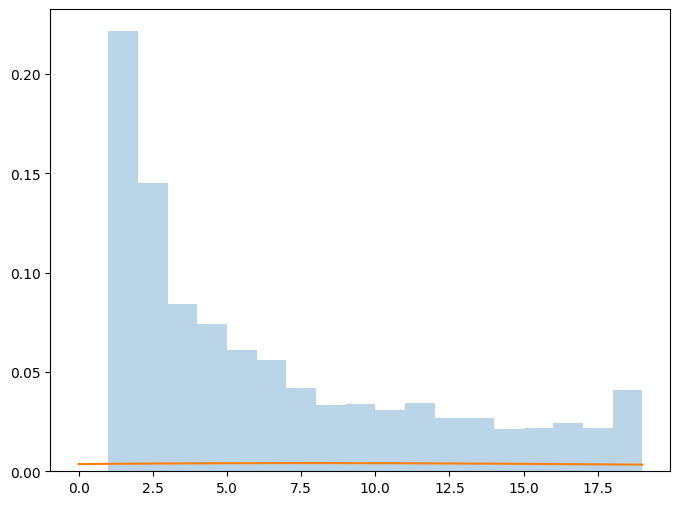

In [296]:
from scipy import stats
fetch_analysis();
load_libraries()

with open(cell_reading_params_path,'rb') as f:
    reading_cells_parameters = pickle.load(f);
with open(metrics_params_path,'rb') as f:
    metrics_params = pickle.load(f)
metrics:pd.DataFrame = pd.read_csv(cell_features_path)

movies = reading_cells_parameters["movies"]

[2489, 2612, 3526, 2899, 3760, 3424, 3605, 2943, 3891, 4002, 1465, 2175]


<Figure size 640x480 with 0 Axes>

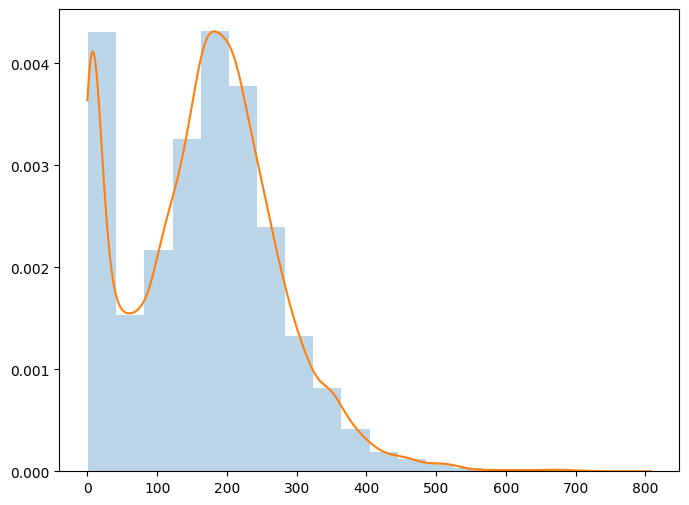

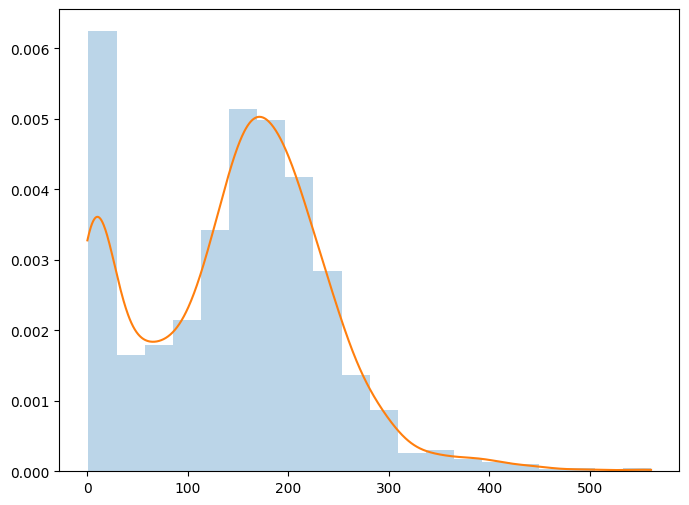

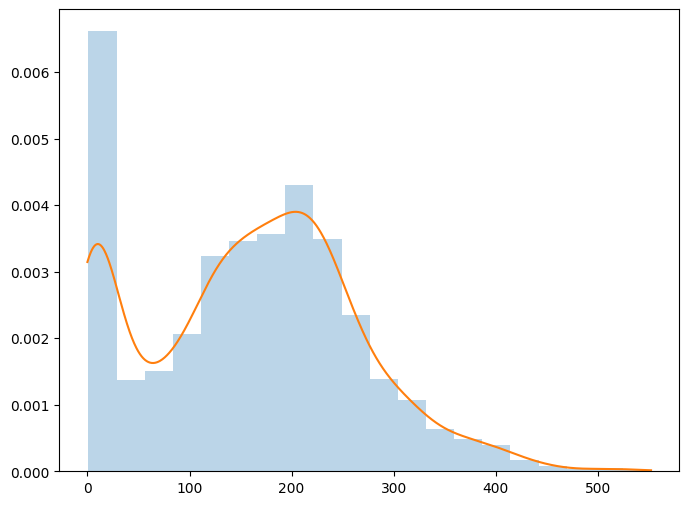

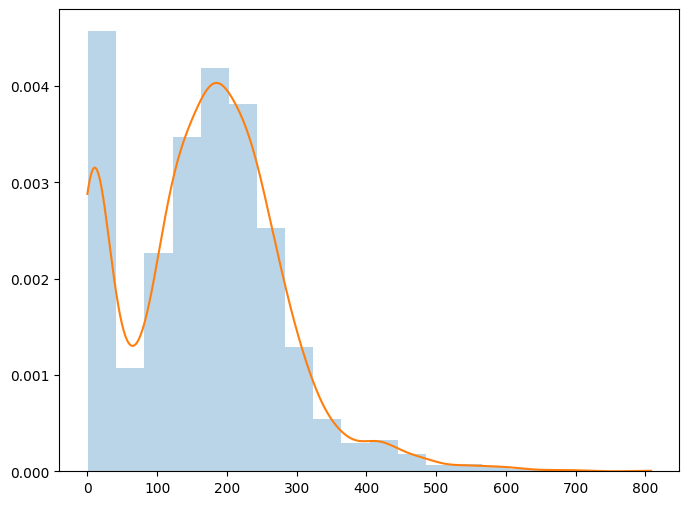

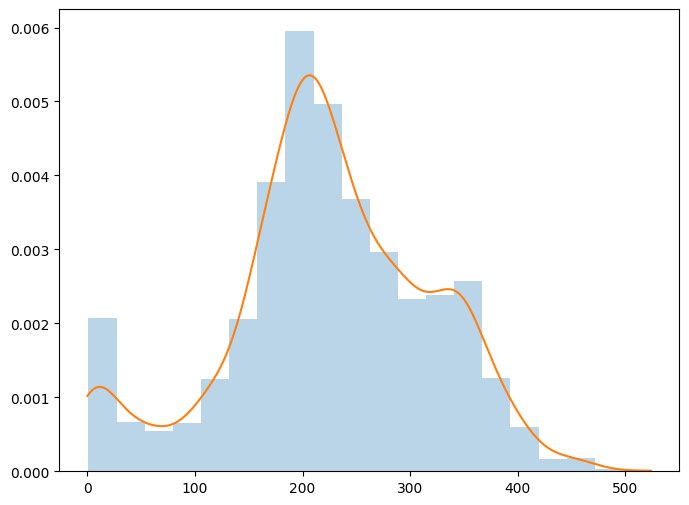

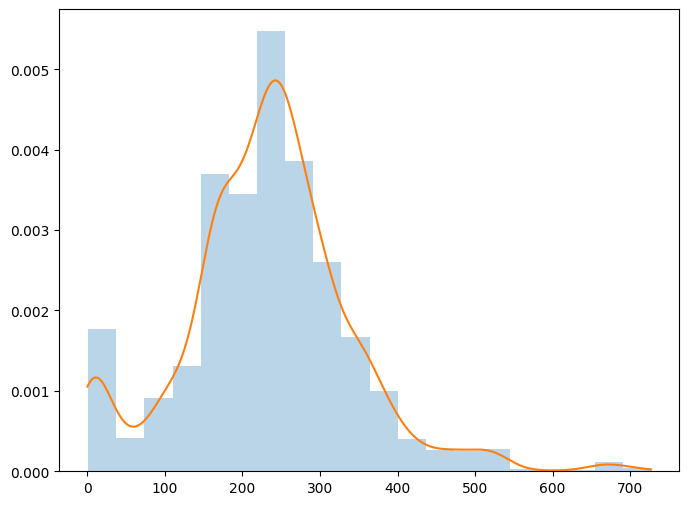

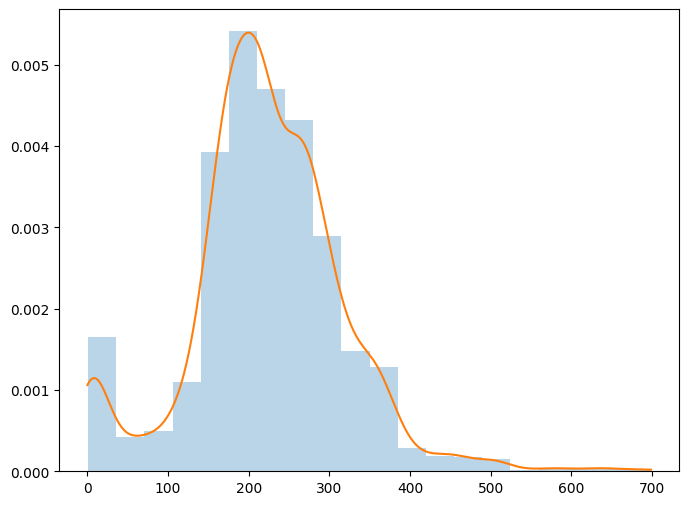

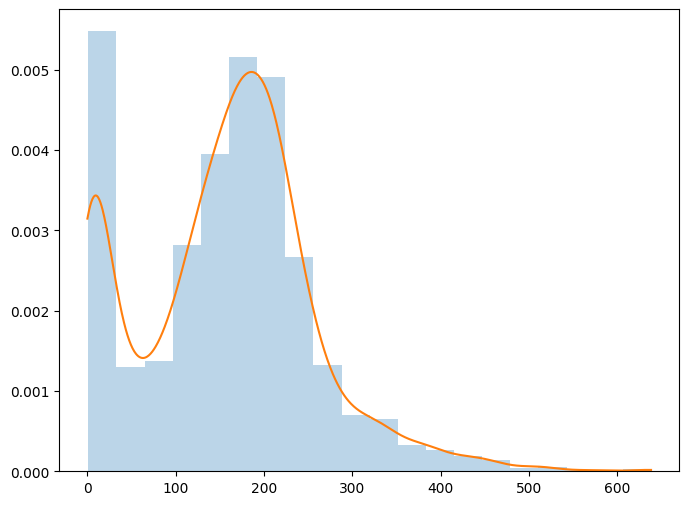

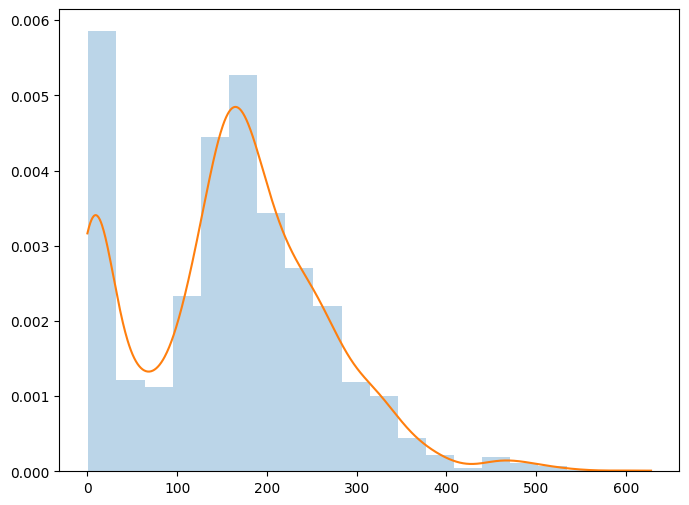

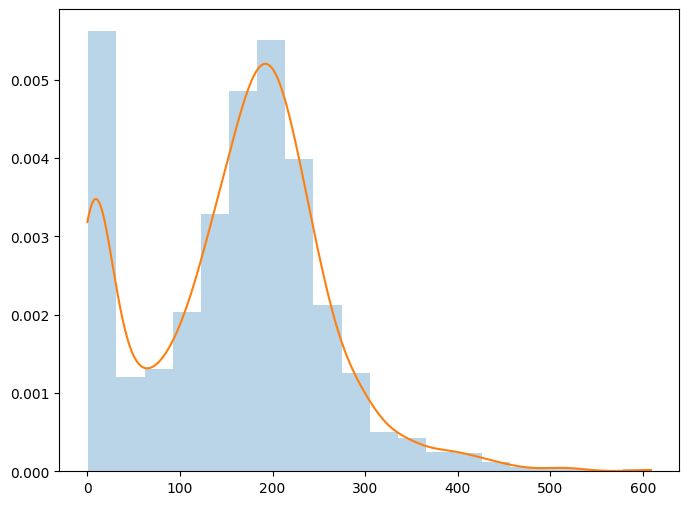

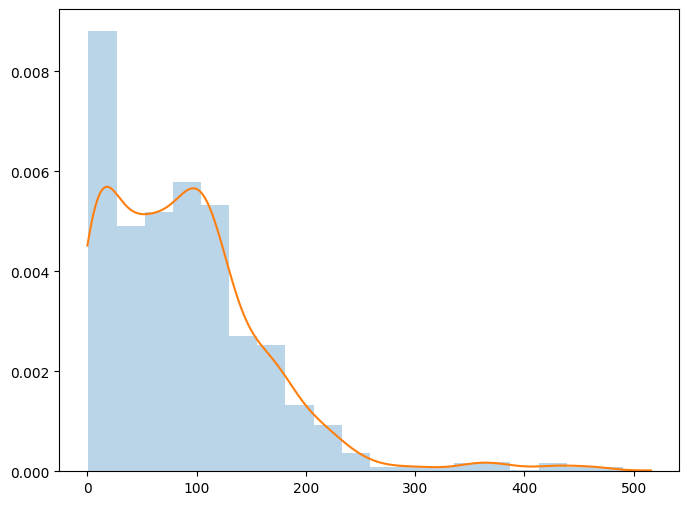

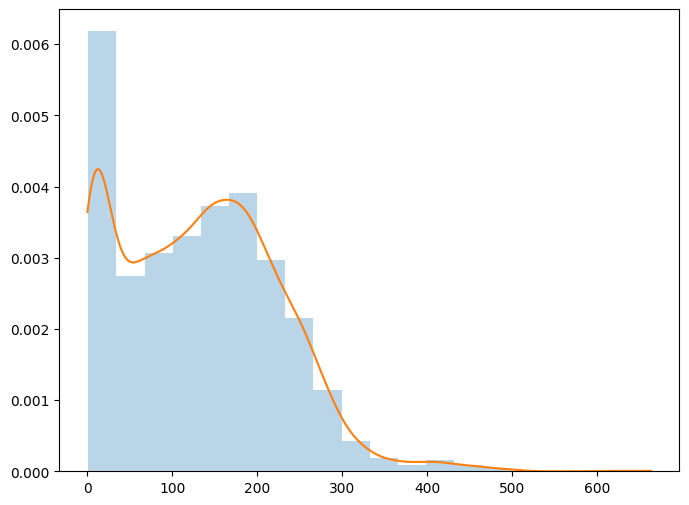

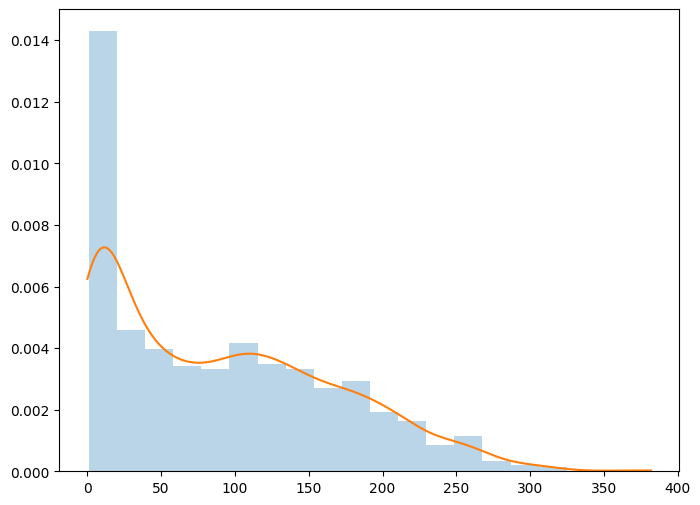

In [306]:

## Measuring metrics: areacell (others??)
## areanuc not contained in cell metrics, visualize some other way
areacell:Dict[int,pd.Series] = {m:metrics[metrics["movie"]==m]["area"] for m in movies} #by movie
totalareacell:pd.Series = metrics["area"]
print([len(x) for x in areacell.values()])

for name,x in zip(["total",*movies],progress_bar([totalareacell,*areacell.values()])):
    nbins = 20
    kde = stats.gaussian_kde(x)
    xx = np.linspace(0, x.max(), 1000)
    plt.figure(name)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.hist(x, density=True, bins=nbins, alpha=0.3)
    ax.plot(xx, kde(xx))
    

# Track Cells (Requires Cell Features)

Reads cell_features from folder_output in GCP bucket, writes tracking_parameters and tracks to folder_output in GCP bucket

 can be either "centroid" or "approximate-medoid"

maxdist is the maximum distance in pixels allowed for a cell jump

dfracsize is the maximum fractional change in area allowed

The output (tracks) should be a file in the output folder ending with "tracks.pkl" containing a list of tables (each table is a track)

In [333]:
fetch_analysis();
load_libraries()

with open(cell_reading_params_path,'rb') as f:
    reading_cells_parameters = pickle.load(f);
if os.path.exists(metrics_params_path):
    with open(metrics_params_path,'rb') as f:
        metrics_params = pickle.load(f)
else:
    if os.path.exists(track_params_path):
        with open(track_params_path,'rb') as f:
            metrics_params = {"centroidtype":pickle.load(f)["centroidype"]}
    else:
        metrics_params = {"centroidtype":"approximate-medoid"}

#@markdown # Cell Tracking Parameters

#@markdown which center type (centroid or medoid) to use for tracking
centroidtype = metrics_params["centroidtype"]
#@markdown maximum jump size allowed in pixels
max_tracked_speed =  30#@param {type:"integer"}
#@markdown maximum fractional area change 
dfracsize=0.9 #@param {type:"number"}



#@markdown ## Disappeared Cell Tracking Parameters
#@markdown #### Filters on how a track whose that has disappeared can snap to a newly appeared cell

#@markdown maximum frames the tracker will remember a cell's position when not in frame before it gets deleted
max_track_disappeared_time =  10 #@param {type:"integer"};

#@markdown minimum length of continuous track required for persistence through disappeared
min_track_persistence_time = 5 #@param {type:"integer"}

options = ["Speed (linear)", "Diffusivity (MSD)"]
class SpeedType(Enum): 
    linear = "linear";
    MSD = "MSD";
    def __str__(self): 
        return self.value;

#@markdown Speed type - whether to use linear speed or mean squared displacement to filter for the distance a cell can move while disappeared
untracked_speed_type_str = "Diffusivity (MSD)" #@param ["Speed (linear)", "Diffusivity (MSD)"]
untracked_speed_type = [SpeedType.linear,SpeedType.MSD][options.index(untracked_speed_type_str)];

#@markdown If using linear speed: maximum average distance a cell that has disappeared can move per frame while still being snapped back to nearest previous position; that is, cell is accepted if distance(C1,C2) < time*max_untracked_speed
max_untracked_speed = 70 #@param {type:"number"}

#@markdown If using MSD: maximum MSD of an cell that has disappeared moving over the course of t frames to be considered the same as a previously tracked cell; that is, cells will be considered the same if distance(C1,C2)^2 < time*max_untracked_diffusivity. First frame's distance will be sqrt(D), then sqrt(2D), then sqrt(3D), etc
max_untracked_diffusivity = 60 #@param {type:"number"}


#@markdown ### Cell Collection: Whether to have only a specific section of movie where new tracks can be added
#@markdown Probably outdated, initial track delay in track qc is probably better, which does the same thing but throughout the movie with after-the-fact information
do_cell_collection = False #@param {type:"boolean"}
#@markdown Cell Collection Time: For how many frames at the begininng of the movie do we still accept new cells
cell_collection_time = 36 #@param {type:"integer"}


trackinging_parameters={
    'centroidtype':centroidtype, 
    'max_tracked_speed':max_tracked_speed, 
    'dfracsize':dfracsize,
    'max_disappeared_time':max_track_disappeared_time,
    'untracked_speed_type':str(untracked_speed_type),
    'do_cell_collection':do_cell_collection,
    'cell_collection_time':cell_collection_time,
    'min_track_persistence_time':min_track_persistence_time};
if untracked_speed_type == SpeedType.linear:
  trackinging_parameters['max_untracked_speed'] = max_untracked_speed;
elif untracked_speed_type == SpeedType.MSD:
  trackinging_parameters['max_untracked_diffusivity'] = max_untracked_diffusivity;


with open(track_params_path, 'wb') as handle:
    pickle.dump(trackinging_parameters, handle)

#This specify the cell metrics tracking is going to use
fields = ['label','movie','frame',centroidtype+'x',centroidtype+'y','area']

#copy cell shape features from bucket to colab
push_analysis();

#read cell shape features as data frame
sample_cells:pd.DataFrame = pd.read_csv(cell_features_path, usecols=fields)

sample:Dict[int,Dict[int,pd.DataFrame]] = {}; #movie index, tracks
# to_use = [m for m in movies if m not in fails] if 'fails' in locals() else movies;

class Cell:
  def __init__(self,frame:pd.DataFrame):
    self.frame = frame;
    self.min_dist = None;
  
  @staticmethod
  def cell_distance(t0:Cell,t1:Cell)->float:
      t0_f = t0.frame.iloc[0];
      t1_f = t1.frame.iloc[0];
      out = math.sqrt((t0_f[centroidtype+'x']-t1_f[centroidtype+'x'])**2 + (t0_f[centroidtype+'y']-t1_f[centroidtype+'y'])**2);
      if (t1.min_dist is None or out < t1.min_dist):
        t1.min_dist = out;
      return out;

  def __str__(self):
    return f"Cell <{builtins.id(self)}>:\nframe: \n" + str(self.frame) + ",\nminimum distance:" + str(self.min_dist)

  @staticmethod
  def cells_filter(t0:Cell,t1:Cell,disappeared_time:int,dist:float)->bool:
    t0_f = None;
    t1_f = None;
    good_area = None;
    try:
      t0_f = t0.frame.iloc[0];
      t1_f = t1.frame.iloc[0];
      # raise Exception();  
      good_area:bool = float(t1_f['area']) > (float(t0_f['area'])*(1-dfracsize)) and float(t1_f['area']) < (float(t0_f['area'])*(1+dfracsize));
    except Exception as e:
      print(t0,t1);
      print(t0_f,t1_f);
      print(t0_f['area'],t1_f['area']);
      print(type(t0_f['area']),type(t1_f['area']));
      print(good_area);
      raise e;

    if disappeared_time == 0:
        result = dist < max_tracked_speed;
    else:
        if untracked_speed_type == SpeedType.linear:
          result = dist < max_untracked_speed*disappeared_time;
        elif untracked_speed_type == SpeedType.MSD:
          result = dist**2 < max_untracked_diffusivity*disappeared_time;
        else:
          raise Exception();

    if not(good_area) and result:
        result = False;

    return result


frames = reading_cells_parameters['frames'];
movies = reading_cells_parameters['movies'];
m = master_bar(movies);
for s in m:
    print(f"tracking movie #{s}");
    tracklists:Dict[int,list[pd.DataFrame]] = {} #objectid, frames
    tracker = CentroidTracker[Cell](
        Cell.cell_distance,
        frame_filter=Cell.cells_filter,
        maxDisappearedFrames=max_track_disappeared_time,
        minPersistenceFrames=min_track_persistence_time);
    for fr in progress_bar(frames[s],parent=m):

        #get cells in current frame
        maskcells:pd.DataFrame = sample_cells[(sample_cells['movie']==s) & (sample_cells['frame']==fr)]

        cells = [Cell(maskcells.iloc[[i]]) for i in range(len(maskcells))];
        objects = tracker.update(cells,allow_new = (fr < cell_collection_time or not(do_cell_collection)));        
        pass;
        for id,cell in objects.items():
            frame = cell.frame.copy();
            if id in tracklists:
              if tracker.disappeared[id] > 0:
                frame['label'] = -1; #disconnect repeated frame from mask label
                frame['frame'] = fr;
              tracklists[id].append(frame);
            else:
              tracklists[id] = [frame];
    
    #concat all tracks together
    tracks:Dict[int,pd.DataFrame] = {tid:pd.concat(tracklists[tid],ignore_index=True) for tid in tracklists}
    sample[s] = tracks

with open(raw_tracks_path, 'wb') as handle:
    pickle.dump(sample, handle)

#transfer tracks and tracking parameters to folder_output in GCP bucket
push_analysis();

print("Tracking complete");

tracking movie #1
tracking movie #2
tracking movie #3
tracking movie #4
tracking movie #5
tracking movie #6
tracking movie #7
tracking movie #8
tracking movie #9
tracking movie #10
tracking movie #11
tracking movie #12
Tracking complete


# Tracking Quality Control

## Get analysis folder data from GCP bucket. Read tracks and cell shape features (centers will be used for display)

In [83]:
fetch_analysis();

with open(cell_reading_params_path,'rb') as handle:
    reading_cells_parameters = pickle.load(handle,encoding='latin1');

with open(track_params_path,'rb') as handle:
    track_params = pickle.load(handle,encoding='latin1');
centertype = track_params['centroidtype'];
    
in_tracks = pd.read_pickle(raw_tracks_path);
to_qc = in_tracks
qc_params = {}


## [Optional] Track Input Validation

In [84]:
#@markdown # Ensure tracking output is clean and orderly

#@markdown basic validation: ensuring movies and frames match track values. Required for more complex validation. Highly recommended as a bare minimum
do_validation = True #@param{type:"boolean"}

#@markdown whether to enforce no gaps or repeat frames (necessary for track spacing and smoothing)
validate_continuity = True #@param{type:"boolean"}


qc_params.update({"do_validation":do_validation,"valid_continuity":validate_continuity})

if do_validation:
    valid_tracks:Dict[int,Dict[int,pd.DataFrame]] = {}
    movies,frames = reading_cells_parameters['movies'],reading_cells_parameters['frames']
    # print(movies,frames)
    for movie,tracks in (m := master_bar(in_tracks.items())):
        valid_tracks[movie] = {}
        for tid,track in progress_bar(tracks.items(),parent=m):
            
            ##basic validation
            track = track.sort_values('frame');
            
            vframes = track['frame'].isin(frames[movie])
            if not vframes.all():
                missing = list(track['frame'][vframes == False])
                #seems unlikely to ever come up, but good to check regardless
                raise Exception(f"Track {tid} in movie {movie} has frames not in the official frame list at frames(s) {missing}")
            
            vmovs = track['movie'].eq(movie)
            if not vmovs.all():
                missing = list(track['frame'][vmovs == False])
                raise Exception(f"Track {tid} in movie {movie} has incorrect movie labels at frame(s) {missing}")
                
            ##validating continuity
            if validate_continuity:
                d = np.diff(track['frame'])
                if (d != 1).any():
                    # print(d)
                    # print(np.argwhere(d != 1))
                    # print(track['frame'])
                    gaps = track['frame'].loc[np.squeeze(np.argwhere(d != 1))]
                    raise Exception(f"Track {tid} in movie {movie} contains nonconsecutive entries around frame(s) {gaps}")

            valid_tracks[movie][tid] = track;        
    print("tracks validated successfully!")
    print("--basic validation checks passed")
    if validate_continuity:
        print("--no discontinuous/repeated frames")
    to_qc = valid_tracks

tracks validated successfully!
--basic validation checks passed
--no discontinuous/repeated frames


## [Optional] Track Spacing and Smoothing

In [85]:
#@markdown # Post Processing on Tracks [Requires Track Validation]

#@markdown ## Spacing: Dropping track points to remove noise
do_spacing = False #@param{type:"boolean"}

#@markdown ### Spacing Gapsize: 1 is every other frame dropped, 2 is every three frames, 0 is no frames dropped
spacing_gapsize = 1 #@param{type:"integer"}


#@markdown ## Smoothing: Averaging between points to adjust for noise 
do_smoothing = True #@param{type:"boolean"}

#@markdown ### Smoothing Width: how wide to do the rolling average. Width of 1 is no smoothing, with of two averages pairs of points, etc
smoothing_width = 2 #@param{type:"integer"}

#@markdown ### Smoothing Power: how many times to repeatedly perform the rolling average. Higher powers are generally less destructive to overall shape than wider averages
smoothing_power = 4 #@param{type:"integer"}

if do_spacing or do_smoothing:
    
    if not (qc_params['do_validation'] and qc_params['valid_continuity'] and "valid_tracks" in globals()):
        raise Exception("Spacing and Smoothing requires tracks validated for continuity. Please enable continuity validation and run the above cell.")

    spsm_tracks:Dict[int,Dict[int,pd.DataFrame]] = {}

    cx,cy = centertype + 'x', centertype + 'y'

    ### guarantees single sets of consecutive, nonrepeating tracks
    for mov,tracks in (m := master_bar(valid_tracks.items())):
        spsm_tracks[mov] = {}
        for tid,track in progress_bar(tracks.items(),parent=m):
            track = track.sort_values('frame');
            if do_spacing:
                track = track[::spacing_gapsize+1]
            if do_smoothing:
                track[cx] = (moving_average**smoothing_power)(track[cx],smoothing_width,include_edges=True)
                track[cy] = (moving_average**smoothing_power)(track[cy],smoothing_width,include_edges=True)
            spsm_tracks[mov][tid] = track



    to_qc = spsm_tracks

tparams = {}
    
tparams['do_spacing'] = do_spacing;
if do_spacing:
    tparams['spacing_gapsize'] = spacing_gapsize;

tparams['do_smoothing'] = do_smoothing
if do_smoothing:
    tparams['smoothing_width'] = smoothing_width
    tparams['smoothing_power'] = smoothing_power

tparams['smoothing_type'] = [['raw','smoothing'],
                             ['spacing','spacing_smoothing']][do_spacing][do_smoothing]
    
qc_params.update(tparams)

## Perform QC operations, push parameters to GCP

keep: {movie:[track1,track2,etc]} - note that any unspecified movies will be left with all tracks

example:
keep={4:[1],6:[1],8:[7],11:[1,2],14:[9],17:[4],18:[1],19:[1],23:[3],24:[1,2,6],28:[1]}

trim: {(movie,track):(firstframe_keep,lastframe_keep)}; if track is -1, will trim the whole movie to that trim

example:
trim={(4,1):(1,6),(17,4):(1,10),(25,1):(1,31),(26,1):(1,6)}

removemov: [movie]

example:
removemov=[1,5,10,12,22,27,30]

exclude: [movie,track]

exclude=[(3,7),(13,2)]

Here "movie" is the number assigned by the microscope, in filename [basename]_s[movie]_t[frame][ext]

In [86]:
load_libraries()

#INPUT QC OPERATIONS 
#@markdown the minimum track length to include (frames)
# minTrackLength=3 #@param {type:"raw"}
minTrackLength = 0

#@markdown the minimum displacement over the length of the track (pixels)
# minTrackDisplacement=3 #@param {type:"raw"}
minTrackDisplacement = 0
# was 65 before 5/24

#@markdown how long to wait after a track's appearance before including it (buffer period for cell division/collisions, segmentation issues, etc)
initialTrackDelay = 0 #@param {type:"raw"}

if qc_params.get("do_spacing",False): #normalize to new track time
    minTrackLength //= (qc_params['spacing_gapsize']+1)
    initialTrackDelay //= (qc_params['spacing_gapsize']+1)


#@markdown dict of {movie:[track1,track2,etc]} specific tracks to keep from particular movies; *only* the tracks specified in the movie will be kept
keep={} #@param {type:"raw"}

#@markdown dict of {(movie,track):(startframe,endframe)} sets the frame bounds of specific tracks in the sample
trim={}  #@param {type:"raw"}

#@markdown list of specific movies to exclude (overrides keep)
removemov=[]  #@param {type:"raw"}

#@markdown list of (movie,track): specific tracks to exclude
exclude=[]  #@param {type:"raw"}

print("starting qc...")
#apply QC operations
sampTrStatus, sample = apply_qc(to_qc,qc_log_path,centertype,
                                keep,
                                trim,
                                removemov,
                                exclude,
                                minTrackLength=minTrackLength,
                                minTrackDisplacement=minTrackDisplacement,
                                initialTrackDelay=initialTrackDelay);
##SampTrStatus: dict of {movie#:statuses}, where statuses is a dict of {trackid:status}; in this case, status = 0 means bad track, status = 1 means good track

trackingChanged = True;

qc_params.update({'tracks_status':sampTrStatus, 'qc_tracks':sample, 
            'minTrackLength':minTrackLength,
            'minTrackDisplacement':minTrackDisplacement,
            'initialTrackDelay': initialTrackDelay,
            'keep':keep, 'trim':trim, 'removemov':removemov, 
            'exclude':exclude})

with open(qc_params_path, 'wb') as handle:
    pickle.dump(qc_params, handle)

tracksreg={}
for imov in sample:
  tracksreg[imov] = {}
  for itr in sample[imov]:
    #if the track satus == 1 (track passed QC)
    if sampTrStatus[imov][itr]==1:
      tracksreg[imov][itr] = (sample[imov][itr])

with open(qc_tracks_path, 'wb') as f:
  pickle.dump(tracksreg,f)



push_analysis();
print("track qc complete")


starting qc...
track qc complete


# [Optional] Visualize Tracks for track QC

**Tracking Quality Control Instructions:**

Select which movie to view by changing the movie field in the cell below and re-running. If you see a track you want to remove or trim, you can edit the options in the cell above and re-run it to apply those edits. If you want to change the tracking parameters themselves, you can change the parameters of the final cell in the previous section (Get Cell Features (table), labeled masks, and track) and re-run it to re-do tracking, then run the previous and following cells.


In [391]:
#@markdown Copy images and masks from GCP to colab (may take a few minutes, zip folders in GCP to speed this up)
cleardir(temp_folder)
with capture_output():
    folderimages = fetch_images();
    foldermasks = fetch_labeled_cellmasks();
    foldernucmasks = fetch_labeled_nucmasks();

In [392]:
#@markdown Load qc tracks
fetch_analysis()
with open(cell_reading_params_path,'rb') as handle:
    reading_cells_parameters = pickle.load(handle,encoding='latin1');
with open(track_params_path,'rb') as handle:
    track_params = pickle.load(handle,encoding='latin1');
centertype = track_params['centroidtype'];
with open(qc_params_path, 'rb') as handle:
    qc_params = pickle.load(handle)
sample = qc_params["qc_tracks"] #get trimmed tracks with invalid movies included
sampTrStatus = qc_params["tracks_status"] #get status of qc'd tracks for visualization

In [406]:
#@markdown ## Input Tracking Display Parameters
#@markdown Nucleus intensity for combined image (between 0 and 1)
nucfrac=0.0 #@param {type:"number"}
nucfrac = float(nucfrac)

#@markdown Frame downsample rate (how often a frame is shown); increase this number for a faster processing time but less fine time-control
frspace=1 #@param {type:"integer"}

#@markdown Mask intensity of cells segmented but not tracked (between 0 and 1);
untracked_intensity = 0.2 #@param {type:"number"}

#@markdown Mask intensity of cells segmented and tracked but excluded from tracking by quality control (will be in red)
excluded_intensity = 0.3 #@param {type:"number"}

#@markdown how much to resize the image by (the more downscaled, the faster the playing but the less the resolution)
downfrac = 0.5 #@param {type:"number"};

#@markdown how large to plot the cell centers (pixels)
centersize = 2 #@param {type:"integer"}

#@markdown how large to draw the track id# (scaling from base size)
textsize =  0.5#@param {type:"number"}

#@markdown ### Track Display

#@markdown how thick to draw the cell tracks
trackwidth = 1#@param {type:"integer"}

trackingChanged = True;


images = {} if 'images' not in globals() or trackingChanged else images; #dict of movie: {True:[with_names],False:[without_names]}
masks = {} if 'masks' not in globals() or trackingChanged else masks; #dict of movie {True:[with_centers],False:[without_centers]}
tracks_images = {} if 'tracks' not in globals() or trackingChanged else tracks_images; #dict of movie:list[tracks]

process_ready = False

In [410]:
#@markdown ##Prepare tracking display function (Required for movie display)

try:
    from google.colab.patches import cv2_imshow
except:
    cv2_imshow = cv2.imshow

textfont = cv2.FONT_HERSHEY_SIMPLEX


imagebasename = reading_cells_parameters['basename'];
ext = reading_cells_parameters['extension']
movies = reading_cells_parameters['movies'];

def get_frame(images,masks,tracks_images,frame,showCenters=False,showNames=False,showTime=False,tracks_display="Neither"):
    image = images[showNames][frame].copy();
    mask = masks[showCenters][frame].copy();
    if tracks_display != "Neither":
      tracks = tracks_images[frame];
      alpha = np.where((tracks != 0).any(axis=2),1,0); #pixels set to 1 where there is at least one nonzero element of the rgb (not black)
      if tracks_display in ["Image side","Both"]:
        overlay_image_alpha(image,tracks,0,0,alpha);

      if tracks_display in ["Mask side","Both"]:
        overlay_image_alpha(mask,tracks,0,0,alpha);


    combined = np.hstack((mask,image))
    combined = rescale_intensity(combined,out_range=np.uint8).astype(np.uint8);
    if showTime:
      combined = cv2.putText(combined,str(frame),(0,combined.shape[0]),textfont,textsize,(255,255,255),1);
    return combined

def f(frame,showCenters=False,showNames=False,tracks_display="Neither"):
  c = get_frame(images,masks,tracks_images,frame,showCenters=showCenters,showNames=showNames);
  l.set_data(c);
  fig.canvas.draw() #use with %matplotlib notebook
  display(fig) #use with %matplotlib inline


def overlay_image_alpha(img, img_overlay, x, y, alpha_mask):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2,:]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o,:]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    alpha_inv = 1.0 - alpha

    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop

def process_movie(movie:int,frames:list,parentbar=None):
    if movie not in movies:
        raise Exception(f"movie selection {movie} not in experimental list of movies {movies}");
    if not process_ready:
        raise Exception("Attempted to process movies with out of date parameters; run the \"Prepare Tracking Function\" Cell")
    movie_tracks = sample[movie];
    print(f"processing movie #{movie}");
    
      
    #random color per id, will be consistent for that id within the movie
    centerColors = DefaultDict(lambda: (random.randrange(0,256),random.randrange(0,256),random.randrange(0,256)));
    grey = (50,50,50);
    [centerColors.update([(id,grey)]) for id,status in sampTrStatus[movie].items() if not status];
      
    acc_tracks_image = None;
    prev_track_pos = None;

    timage = {True:{},False:{}}
    tmask = {True:{},False:{}}
    ttrack_images = {}

    for i in progress_bar(frames,parent=(parentbar or None)):
        filename_mask = imagebasename + "_s" + str(movie)+"_t"+str(i)+".png";
        try:
            maskmem = imread(foldermasks/filename_mask);
            masknuc = imread(foldernucmasks/filename_mask);
        except:
            filename_mask = imagebasename + "_s" + str(movie) + "_t" + str(i) + ext
            maskmem = imread(foldermasks/filename_mask)
            masknuc = imread(foldermasks/filename_mask)
          
        #read image
        filename_img = imagebasename + "_s" + str(movie)+"_t"+str(i)+ext;
        imageorig = imread(folderimages/filename_img)

        imageorig = rescale_intensity(imageorig);
        image=resize(imageorig, (maskmem.shape[0] * downfrac , maskmem.shape[1] * downfrac),  anti_aliasing=True); #this order matters so that the data types work out
        image = rescale_intensity(image,out_range=np.uint8).astype(np.uint8);
        rmem = resize(maskmem,image.shape,anti_aliasing=True)
        masked_image = image*(0.7 + rmem/np.max(rmem)*0.3)
        nmasked_image = image*(0.7 + (1-rmem/np.max(rmem))*0.3)
        image = np.stack((nmasked_image,masked_image,image*0.7),axis=2); #make color image 
          
          
        trackedLabels = [];
        rejectedLabels = [];
        centers = {};
        for tid,data in movie_tracks.items():
            fDat = data[data['frame']==i];
            if not fDat.empty:
                trackedLabels.append(fDat)
                if not sampTrStatus[movie][tid]:
                    rejectedLabels.append(fDat);
                centers[tid] = fDat[[centertype+'x',centertype+'y']].reset_index();
          
          
        #get the label of every tracked mask in this frame
        trackedLabels = pd.concat(trackedLabels)['label'] if len(trackedLabels) > 0 else [];
        rejectedLabels = pd.concat(rejectedLabels)['label'] if len(rejectedLabels) > 0 else []


        #create bitmasks of untracked and rejected cells
        cellmask = (maskmem != 0);
        untracked = np.isin(maskmem,trackedLabels,invert=True) & cellmask
        rejected = np.isin(maskmem,rejectedLabels);
          
        #draw tracks
        if acc_tracks_image is None:
            acc_tracks_image = np.zeros(np.array(image.shape),dtype=np.uint8);
            prev_track_pos = centers;
        else:
            for id in centers:
                if id in prev_track_pos:
                    prev = prev_track_pos[id];
                    prev = (int(prev[centertype+'x'][0]*downfrac),int(prev[centertype+'y'][0]*downfrac));

                pos = centers[id];
                pos = (int(pos[centertype+'x'][0]*downfrac),int(pos[centertype+'y'][0]*downfrac));

                acc_tracks_image = cv2.line(acc_tracks_image,prev,pos,centerColors[id],trackwidth);
            prev_track_pos = centers;

        ttrack_images[i] = acc_tracks_image.copy();        

        #unlabel for visualization
        maskmem[maskmem>=1] = 1

        #combine membrane and nucleus masks
        maskcomb = (maskmem - nucfrac*masknuc)
        maskcomb[maskcomb<0]=0; #floating point stuff, this is so stupid

        #apply untracked and excluded intensities
        maskcomb[untracked] *= untracked_intensity;
        maskcomb[rejected] *= excluded_intensity

        #rescale to full intensity, make int8 again
        maskcomb = rescale_intensity(maskcomb,out_range=np.uint8).astype(np.uint8);

        #color rejected cells red
        qcomb = (maskcomb//4).astype(maskcomb.dtype);
        halfmask = np.where(rejected,qcomb,maskcomb);
          
        #turn into rgb image
        maskcomb = np.stack((maskcomb,halfmask,halfmask),axis=2);

        #downscale
        maskcomb=resize(maskcomb,(int(maskcomb.shape[0]*downfrac), int(maskcomb.shape[1]*downfrac)),preserve_range=True).astype(np.uint8);

        #save unannotated frames
        tmask[False][i] = maskcomb.copy();
        timage[False][i] = image.copy();

        #annotate with centers and names
        for id,pos in centers.items():
            pos = (int(pos[centertype+'x'][0]*downfrac),int(pos[centertype+'y'][0]*downfrac));
            maskcomb = cv2.circle(maskcomb,pos,2,centerColors[id],-1);
            image = cv2.putText(image,str(id),pos,textfont,textsize,centerColors[id],1);

        #save annotated frames
        tmask[True][i] = maskcomb;
        timage[True][i] = image;
    return timage,tmask,ttrack_images

process_ready = True

In [412]:

#@markdown ### Compute Tracking Display Frames
#@markdown Get combined images & masks for visualization, draw mask centers and labeled names

#@markdown Which movie to load
movie_selection=2 #@param {type:"integer"}

#@markdown if you want to process the other movies while loading the selection
process_all = False #@param {type:"boolean"}

#@markdown Force reprocessing of selected movie (select if running this cell with new data/parameters says "previously prepared)
force_reprocess = False #@param {type:"boolean"}

to_process = master_bar(movies) if process_all else [movie_selection];


for movie in to_process:
  frames = reading_cells_parameters['frames'][movie][::frspace];

  movie_tracked = True;
  if movie not in images or len(images[movie][True]) != len(frames):
    movie_tracked = False;
  if movie not in masks or len(masks[movie][True]) != len(frames):
    movie_tracked = False;
  if movie not in tracks_images or len(tracks_images) != len(frames):
    movie_tracked = False;

  if not movie_tracked or (movie == movie_selection and force_reprocess):
    images[movie],masks[movie],tracks_images[movie] = process_movie(movie,frames,to_process if process_all else None);
trackingChanged = False;

processing movie #2


In [413]:
#@markdown ## View Tracking Output - Mediapy
#@markdown ### (Requires computing display frames for selected movie)
#@markdown #-
#@markdown ### Mediapy results in a much cleaner video experience than matlab, but can't be changed dynamically
#@markdown Framerate: speed of movie playing in frames per second (not limited by processing time, can go as fast as you want);
framerate =  1#@param {type:"number"}
#@markdown ### Annotation Parameters:
centers = True #@param {type:"boolean"}
names = True #@param {type:"boolean"}
frameNumber = True #@param {type:"boolean"}
#@markdown whether and where to draw the tracks of each cell on the image frames
display_tracks_side = "Neither" #@param ["Neither", "Mask side", "Image side", "Both"]



frlist = [[f] for f in reading_cells_parameters['frames'][movie][::frspace]];
print(frlist)
try:
  media.show_video(starmap(partial(get_frame,images[movie_selection],masks[movie_selection],tracks_images[movie_selection],showCenters=centers,showNames=names,showTime=frameNumber,tracks_display=display_tracks_side),progress_bar(frlist)),fps=framerate);
except NameError as e:
  raise Exception("Unable to load movie - did you set up the frame function?") from e;
except KeyError as k:
  raise Exception("Unable to load entire movie - run the parameters and computation cells to ensure full movie complete") from k;


[[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30]]


In [422]:
#@markdown ## Save Video Output (Tiff Stack)
#@markdown ### Annotation Parameters:
centers = True #@param {type:"boolean"}
names = True #@param {type:"boolean"}
frameNumber = True #@param {type:"boolean"}
#@markdown whether and where to draw the tracks of each cell on the image frames
display_tracks_side = "Neither" #@param ["Neither", "Mask side", "Image side", "Both"]

frlist = [[f] for f in reading_cells_parameters['frames'][movie][::frspace]];
frames = starmap(partial(get_frame,images[movie_selection],masks[movie_selection],tracks_images[movie_selection],showCenters=centers,showNames=names,showTime=frameNumber,tracks_display=display_tracks_side),progress_bar(frlist))
import tifffile


def peek_iterator(iterator: Iterator[Any]) -> Tuple[Any, Iterator[Any]]:
    """Return first item of iterator and iterator.

    >>> first, it = peek_iterator(iter((0, 1, 2)))
    >>> first
    0
    >>> list(it)
    [0, 1, 2]

    """
    first = next(iterator)

    def newiter(first=first, iterator=iterator):
        yield first
        yield from iterator

    return first, newiter()

fframe,frames = peek_iterator(frames)
# print(fframe)
# print(fframe.dtype)
outfilename = "movie{movie}.tiff"
outfilename = format_path(outfilename,experiment=experiment,movie=movie)
outfile = local_analysis_output_folder/outfilename
with tifffile.TiffWriter(outfile) as writer:
    writer.write(frames,dtype=fframe.dtype,shape=(len(frlist),*fframe.shape))



In [ ]:
#@markdown ## Save Video Output (Mediapy)
#@markdown ### (Requires computing display frames for selected movie)
#@markdown #-
#@markdown Framerate: speed of movie playing in frames per second (not limited by processing time, can go as fast as you want);
framerate = 3#@param {type:"number"}
#@markdown ### Annotation Parameters:
centers = True #@param {type:"boolean"}
names = True #@param {type:"boolean"}
frameNumber = True #@param {type:"boolean"}
#@markdown whether and where to draw the tracks of each cell on the image frames
display_tracks_side = "Mask side" #@param ["Neither", "Mask side", "Image side", "Both"]

#@markdown GCP output filename (to automatically name the path based on movie#, put "{movie}" in the name)
gcp_out_path = "trackqc_using_cell_collection_ex41_mov{movie}.mp4" #@param {type:"string"}
gcp_out_path:Path = Path(format_path(gcp_out_path,movie=movie_selection,collection=track_params['do_cell_collection']));

#@markdown ##### Treat the above path as relative to the experiment's analysis output folder?
in_analysis = True #@param {type:"boolean"}

local_path = local_analysis_output_folder / gcp_out_path if in_analysis else temp_folder / Path(gcp_out_path).name
gcp_out_path = gcp_analysis_output_folder / gcp_out_path if in_analysis else Path(gcp_out_path);
frlist = [[f] for f in reading_cells_parameters['frames'][movie][::frspace]];
try:
  media.write_video(local_path,starmap(partial(get_frame,images[movie_selection],masks[movie_selection],tracks_images[movie_selection],showCenters=centers,showNames=names,showTime=frameNumber,tracks_display=display_tracks_side),progress_bar(frlist)),fps=framerate);
except NameError as e:
  raise Exception("Unable to load movie - did you set up the frame function?") from e;
except KeyError as k:
  raise Exception("Unable to load entire movie - run the parameters and computation cells to ensure full movie complete") from k;

!gsutil -m cp "{gs_str(local_path)}" "{gs_str(gcp_out_path)}"


In [ ]:
#@markdown ## Process and save range of movies
#@markdown ### Requires process function initialization, but not computing display frames for the selected movies
#@markdown #-
#@markdown ## Doing it in batches saves interaction time and doesn't remember results, freeing up fram usage
#@markdown If movie is -1, will include all movies
movie = -1#@param{type:"integer"}

#@markdown If you want to include a range of movies, setting this to a positive number will process all movies from movie to movie_end
movie_end =  12#@param{type:"integer"}

selected_movies = [];
if movie == -1:
    selected_movies = sample.keys()
elif movie_end > 0:
    selected_movies = [m for m in range(movie,movie_end+1) if m in sample]
elif (movie not in sample):
   raise Exception(f"Error: movie #{movie} not in experimental movies {list(sample.keys())}");
else:
    selected_movies = [movie];

print("processing movies",list(selected_movies))

#@markdown Framespace: how often a frame is included (1 is every frame, 2 is every other frame, etc)
framespace = 1#@param {type:"integer"}
#@markdown Framerate: speed of movie playing in frames per second (not limited by processing time, can go as fast as you want);
framerate = 3#@param {type:"number"}
#@markdown ### Annotation Parameters:
centers = True #@param {type:"boolean"}
names = True #@param {type:"boolean"}
frameNumber = True #@param {type:"boolean"}
#@markdown whether and where to draw the tracks of each cell on the image frames
display_tracks_side = "Mask side" #@param ["Neither", "Mask side", "Image side", "Both"]

#@markdown GCP output filename (Supported formatting: {collection}, {movie})
gcp_out_str = "trackqc_mov{movie}.mp4" #@param {type:"string"}
#@markdown ##### Treat the above path as relative to the experiment's analysis output folder?
in_analysis = True #@param {type:"boolean"}
bar = master_bar(selected_movies)
for movie in bar:
  
  gcp_out_path = Path(format_path(gcp_out_str,movie=movie,collection=track_params['do_cell_collection'],qc_params=qc_params));

  local_path = local_analysis_output_folder / gcp_out_path if in_analysis else temp_folder / Path(gcp_out_path).name
  gcp_out_path = gcp_analysis_output_folder / gcp_out_path if in_analysis else Path(gcp_out_path);

  frames = reading_cells_parameters['frames'][movie][::framespace];

  # print(frames);
  args = process_movie(movie,frames,parentbar=bar);

  try:
    media.write_video(local_path,map(partial(get_frame,*args,showCenters=centers,showTime=frameNumber,showNames=names,tracks_display=display_tracks_side),progress_bar(frames)),fps=framerate,crf=25); #lower crf is higher quality
  except NameError as e:
    raise Exception("Unable to load movie - did you set up the frame function?") from e;
  except KeyError as k:
    raise Exception("Unable to load entire movie - run the parameters and computation cells to ensure full movie complete") from k;

  del args

  !gsutil -m cp "{gs_str(local_path)}" "{gs_str(gcp_out_path)}"
    
push_analysis();



In [423]:
#@markdown ## Process and save range of Tiff Stacks
#@markdown ### Requires process function initialization, but not computing display frames for the selected movies
#@markdown #-
#@markdown ## Doing it in batches saves interaction time and doesn't remember results, freeing up fram usage
#@markdown If movie is -1, will include all movies
movie = -1#@param{type:"integer"}

#@markdown If you want to include a range of movies, setting this to a positive number will process all movies from movie to movie_end
movie_end =  12#@param{type:"integer"}

selected_movies = [];
if movie == -1:
    selected_movies = sample.keys()
elif movie_end > 0:
    selected_movies = [m for m in range(movie,movie_end+1) if m in sample]
elif (movie not in sample):
   raise Exception(f"Error: movie #{movie} not in experimental movies {list(sample.keys())}");
else:
    selected_movies = [movie];

print("processing movies",list(selected_movies))

def peek_iterator(iterator: Iterator[Any]) -> Tuple[Any, Iterator[Any]]:
    """Return first item of iterator and iterator.

    >>> first, it = peek_iterator(iter((0, 1, 2)))
    >>> first
    0
    >>> list(it)
    [0, 1, 2]

    """
    first = next(iterator)

    def newiter(first=first, iterator=iterator):
        yield first
        yield from iterator

    return first, newiter()


#@markdown Framespace: how often a frame is included (1 is every frame, 2 is every other frame, etc)
framespace = 1#@param {type:"integer"}
#@markdown ### Annotation Parameters:
centers = True #@param {type:"boolean"}
names = True #@param {type:"boolean"}
frameNumber = True #@param {type:"boolean"}
#@markdown whether and where to draw the tracks of each cell on the image frames
display_tracks_side = "Mask side" #@param ["Neither", "Mask side", "Image side", "Both"]

#@markdown GCP output filename (Supported formatting: {collection}, {movie})
gcp_out_str = "movie{movie}.tiff" #@param {type:"string"}
#@markdown ##### Treat the above path as relative to the experiment's analysis output folder?
in_analysis = True #@param {type:"boolean"}
bar = master_bar(selected_movies)
for movie in bar:
  
  gcp_out_path = Path(format_path(gcp_out_str,movie=movie,collection=track_params['do_cell_collection'],qc_params=qc_params));

  local_path = local_analysis_output_folder / gcp_out_path if in_analysis else temp_folder / Path(gcp_out_path).name
  gcp_out_path = gcp_analysis_output_folder / gcp_out_path if in_analysis else Path(gcp_out_path);

  frames = reading_cells_parameters['frames'][movie][::framespace];

  # print(frames);
  args = process_movie(movie,frames,parentbar=bar);

  iterator = map(partial(get_frame,*args,showCenters=centers,showTime=frameNumber,showNames=names,tracks_display=display_tracks_side),progress_bar(frames))

  fframe,iterator = peek_iterator(iterator)

  with tifffile.TiffWriter(local_path) as writer:
    writer.write(frames,dtype=fframe.dtype,shape=(len(frlist),*fframe.shape))
  del args

  !gsutil -m cp "{gs_str(local_path)}" "{gs_str(gcp_out_path)}"
    
push_analysis();



processing movies [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


processing movie #1


ValueError: shape argument does not match data shape

In [ ]:
#@markdown ## View Tracking Output - Matplotlib
#@markdown ### Slower and rougher playing experience, but dynamically changeable
import time
import ipywidgets
#@markdown Framerate: how quickly movie will be shown in frames per second (will be limited by image display speed)
framerate =  2#@param {"type":"number"}
delay = 1/framerate;


fig = plt.figure(figsize=(14, 8))
ax_mask = fig.add_subplot(111) 
l = ax_mask.imshow(get_frame(frames[0]));


play = widgets.Play(
    min=frames[0],
    max=frames[-1],
    step=frspace,
    value=frames[0],
    interval=delay*1000,
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider(msg_throttle=1)
widgets.jslink((play, 'value'), (slider, 'value'))
# display(widgets.HBox([play, slider]))
display(play);
interact(f,frame=slider,showCenters=False,showNames=False);


# Save masks for tracks in tiff stacks

In [29]:
reading_cells_parameters["ext"] =".TIF"
pd.to_pickle(reading_cells_parameters,cell_reading_params_path)
push_analysis()

In [30]:
fetch_analysis()
print("analysis fetched")
reading_cells_parameters = pd.read_pickle(cell_reading_params_path)
basename = reading_cells_parameters["basename"]
ext = reading_cells_parameters["ext"]

#function to read a mask corresponding to a given movie (implicit parameter), and frame (explicit parameter iframe)
#get_mask = lambda iframe: imread( masks_folder/basename+'_s'+str(int(movie))+'_t'+str(int(frame[iframe]))+'.TIF')
def get_mask(movie,iframe):
    filename = basename+'_s'+str(int(movie))+'_t'+str(int(frame[iframe]))
    try:
        return imread(masks_folder/(filename+".png")
    except:
        return imread(masks_folder/(filename+ext))

#function that returns the mask of a cell centered. It takes the cell label in the mask, and the movie
#as implicit parameters determined by the track information (as used later). 
def get_centered_cell(movie,iframe):
  mask=get_mask(movie,iframe)
  #erase all objects with different label as cell
  mask[mask != label[iframe] ] =0
  #set cell positions as 1
  mask[mask > 0 ] = 1
  props = measure.regionprops(mask)
  #center image
  centroid=props[0].centroid
  N=mask.shape
  centered=mask[np.ix_((np.arange(N[0]) + int(centroid[0]) - int(N[0]/2)) % N[0] , (np.arange(N[1]) + int(centroid[1]) - int(N[1]/2)) % N[1])]
  return centered

#function that returns the mask of a cell. It takes the cell label in the mask, and the movie
#as implicit parameters determined by the track information (as used later).
def get_cell(movie,iframe):
  mask=get_mask(movie,iframe)  
  #erase all objects with different label as cell
  mask[mask != label[iframe] ] =0
  #set cell positions as 1
  mask[mask > 0 ] = 1

  return mask

rotation_matrix = lambda angle: np.asarray([[np.cos(angle) , -np.sin(angle)],[np.sin(angle), np.cos(angle)]] )


def skew_from_hist(hist):
  value = np.asarray(range(len(hist)))
  mean = np.sum(hist*value)/np.sum(hist)
  m2 = np.sum(hist*(value-mean)**2)/np.sum(hist)
  m3 = np.sum(hist*(value-mean)**3)/np.sum(hist)
  return  m3/m2**(3/2) 


In [ ]:
cleardir(temp_folder)

masks_folder = fetch_labeled_cellmasks()
print("cellmasks fetched")
#read pickled tracks
#unpickle tracks  
tracks_noshape = pd.read_pickle(qc_tracks_path)

#create folder to store masks from tracks
if not os.path.exists(temp_folder/'tracks_masks'):
  os.mkdir(temp_folder/'tracks_masks');
#!mkdir temp_folder/tracks_masks


###Loop to add features to each timepoint of all the tracks
#Add morphological and morphodynamical features to each timepoint (frame) in the tracks

tracks = copy.copy(tracks_noshape)

for movie in (m := master_bar(tracks)):
  for itrack in progress_bar(tracks[movie],parent=m):
    tracklength = len(tracks[movie][itrack])
    frame = list(tracks[movie][itrack]['frame'])
    label = list(tracks[movie][itrack]['label'])
    masks=os.listdir(masks_folder)
    #implicit argument to read cells
    basename=re.findall(r"(.+)_s",masks[0])[0] 

    track_masks=[]


    #GET SCIKIT-IMAGE CELL METRICS AND SAVE CELL MASK
    for iframe in range(tracklength):
      cell = get_cell(movie,iframe) 

      #store cell mask
      track_masks.append(cell)

    #SAVE TRACK MASKS AS TIFF STACKS
    track_masks = np.asarray(track_masks)
    savepath = "tracks_masks/" + experiment + "_movie" + str(movie) + "_track"+ str(itrack) + '.TIF'
    imsave(temp_folder/savepath , track_masks, check_contrast=False, metadata={"startframe":min(frame)})

print("trackmasks created")
    

analysis fetched
cellmasks fetched


trackmasks created


In [23]:
#transfer data (tracks_masks and tracks_shape) to GCP bucket
cmd_zip(f"{temp_folder}/tracks_masks",f"{local_analysis_output_folder}/tracks_masks.zip",recurse=True,bar=True)

print("trackmasks zipped")
push_analysis();

temp/tracks_masks


trackmasks zipped


# Shape2tracks - tracks with shape info

In [ ]:
#@markdown label of substrate or region on gel where experiment was taken

region = 'gel' #@param {type:"string"}

In [ ]:
fetch_analysis();


#unzip labeld masks
#!unzip {local_analysis_output_folder}/labeledmasks.zip

masks_folder = fetch_labeled_cellmasks()

#read pickled tracks
#unpickle tracks  
with open(qc_tracks_path, 'rb') as handle:
  tracks_noshape = pickle.load(handle, encoding='latin1') 


###Loop to add features to each timepoint of all the tracks
#Add morphological and morphodynamical features to each timepoint (frame) in the tracks

tracks = copy.copy(tracks_noshape)

for movie in tracks:
  for itrack in tracks[movie]:
    tracklength = len(tracks[movie][itrack])
    #store experiment and id_track, to retrieve track_masks from track
    tracks[movie][itrack]["experiment"]=experiment
    tracks[movie][itrack]["region"]=region
    tracks[movie][itrack]["track_id"]=itrack
    #read data to retrieve corresponding labeled mask cell
    #movie = tracks[itrack]['movie'].iloc[0]
    frame = list(tracks[movie][itrack]['frame'])
    label = list(tracks[movie][itrack]['label'])
    masks=os.listdir(masks_folder)
    #implicit argument to read cells
    basename=re.findall(r"(.+)_s",masks[0])[0] 

    #get polarization angle, skew, protrusion and retraction angle,norm area, radii 

    median_centroidy = []
    median_centroidx = []
    protrusion_angles=[]
    mean_protrusion_angles=[]
    protrusion_norm_radii =[]
    protrusion_norm_areas=[]
    retraction_angles=[]
    mean_retraction_angles=[]
    retraction_norm_areas=[]
    retraction_norm_radii=[]
    mean_retraction_norm_radii=[]
    mean_protrusion_norm_radii =[]

    cell_angles = []
    cell_skews = []

    #select scikit-image shape metrics
    shape_metrics = ['area','convex_area','eccentricity','orientation','perimeter','equivalent_diameter','solidity','extent','major_axis_length','minor_axis_length','centroid']

    track_shape_metrics = pd.DataFrame()

    #GET SCIKIT-IMAGE CELL METRICS AND SAVE CELL MASK
    for iframe in range(tracklength):
      cell = get_cell(iframe) 
      if np.any(cell) == False:
        cell_shape_metrics = measure.regionprops_table(cell, properties = shape_metrics)        
        cell_shape_metrics=pd.DataFrame(cell_shape_metrics)
        row = np.empty(len(shape_metrics)+1)
        row[:] = np.nan
        cell_shape_metrics = cell_shape_metrics.append(pd.Series(row, index=cell_shape_metrics.columns),ignore_index=True)
        #append cell shape metrics to track shape metrics
        track_shape_metrics = track_shape_metrics.append(cell_shape_metrics, ignore_index=True)
        #get median calculated centroid
        celly = np.array(np.nan)
        cellx = np.array(np.nan)
        median_centroidy.append( np.median(celly) ) 
        median_centroidx.append( np.median(cellx) )
      else:
        cell_shape_metrics = measure.regionprops_table(cell, properties = shape_metrics)        
        cell_shape_metrics=pd.DataFrame(cell_shape_metrics)
        #append cell shape metrics to track shape metrics
        track_shape_metrics = track_shape_metrics.append(cell_shape_metrics, ignore_index=True)
        #get median calculated centroid
        celly,cellx = np.where(cell)
        median_centroidy.append( np.median(celly) ) 
        median_centroidx.append( np.median(cellx) )



    for iframe in range(tracklength-1):

      #GET CELL POLARIZATION ANGLE 
      cell = get_cell(iframe)
      if np.any(cell) == False:
        cell_angles.append( np.nan )
        cell_skews.append(np.nan)
      else:
        cell_centered = get_centered_cell(iframe)
        props = regionprops(cell_centered)
        #major axis angle with respect to y (0 axis : rows) counter-clockwise -pi/2 , pi/2  
        angle_y = props[0].orientation
        #rotate cell so that major axis is aligned with the y axis
        cell_y = rotate(cell_centered,-angle_y*180/np.pi,order=0, preserve_range=True)
        #project cell on the x (1) axis
        proj_x = np.sum(cell_y,1)      
        #get cell polarization vector in a regular coordinate system
        #skew sign corresponds to the tail of the distribution, cell polarization is  
        #defined here as -skew. Because image y-axis is inverted, in a regular coordinate
        #system, cell polarization vector is defined as -(-skew) = skew:
        skew_cell = skew_from_hist(proj_x)
        celly_polarization = [0 , skew_cell ]      
        #rotate back
        polarization = np.dot( rotation_matrix(angle_y) , celly_polarization )
        cell_angles.append( np.arctan2(polarization[1],polarization[0]) )
        cell_skews.append(abs(skew_cell)) 


      #PROTRUSION AND RETRACTION VECTORS : angle, norm_areas, radii (calculated with medians)
      if np.any(cell) == False or np.any(get_cell(iframe+1)) == False:
        protrusion_angles.append( np.nan )
        protrusion_norm_areas.append(np.nan)
        #effective radius (area/pi)^0.5
        protrusion_norm_radii.append( np.nan )
        retraction_angles.append(np.nan)
        retraction_norm_areas.append( np.nan )
        retraction_norm_radii.append( np.nan )
        mean_protrusion_angles.append(np.nan)
        mean_retraction_angles.append(np.nan )
        mean_protrusion_norm_radii.append( np.nan )
        mean_retraction_norm_radii.append( np.nan )

        med_centroids = pd.DataFrame({'median_centroidx':[np.nan], 'median_centroidy':[np.nan]})

      else:
        difference  = get_centered_cell(iframe+1) - get_centered_cell(iframe)
        #get centroids of cell(iframe), protrusion and retraction
        y,x =np.where(get_centered_cell(iframe))
        centroidy, centroidx = np.median(y), np.median(x)
        yp,xp = np.where(difference==1)
        protrusion_y, protrusion_x  = np.median(yp) , np.median(xp)
        yr,xr = np.where(difference==-1)
        retraction_y, retraction_x  = np.median(yr) , np.median(xr) 
        #get protr and retr angle in a regular coordinate system: [ximage , - yimage]
        #and norm_areas
        protrusion_angles.append( np.arctan2( -(protrusion_y - centroidy) , protrusion_x - centroidx) )
        protrusion_norm_areas.append(len(yp)/ len(y))
        #effective radius (area/pi)^0.5
        protrusion_norm_radii.append( ((protrusion_x-centroidx)**2+(protrusion_y-centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )
        retraction_angles.append(np.arctan2( -(retraction_y - centroidy), retraction_x - centroidx)  )
        retraction_norm_areas.append( len(yr)/len(y) )
        retraction_norm_radii.append( ((retraction_x-centroidx)**2+(retraction_y-centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )


        #PROTRUSION AND RETRACTION angles, radii, calculated with means
        #get centroids of cell(iframe), protrusion and retraction
        mean_centroidy, mean_centroidx = np.mean(y), np.mean(x)
        mean_protrusion_y, mean_protrusion_x  = np.mean(yp) , np.mean(xp)
        mean_retraction_y, mean_retraction_x  = np.mean(yr) , np.mean(xr) 
        #get protr and retr angle in a regular coordinate system: [ximage , - yimage]
        #and norm_areas
        mean_protrusion_angles.append(np.arctan2( -(mean_protrusion_y - mean_centroidy), mean_protrusion_x - mean_centroidx) )
        mean_retraction_angles.append(np.arctan2( -(mean_retraction_y - mean_centroidy), mean_retraction_x - mean_centroidx) )
        mean_protrusion_norm_radii.append( ((mean_protrusion_x-mean_centroidx)**2+(mean_protrusion_y-mean_centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )
        mean_retraction_norm_radii.append( ((mean_retraction_x-mean_centroidx)**2+(mean_retraction_y-mean_centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )


        med_centroids = pd.DataFrame({'median_centroidx':median_centroidx, 'median_centroidy':median_centroidy})

    shape_features= pd.DataFrame({'polarity_angle':cell_angles, 'abs-skew':cell_skews, 
                              'protr_angle':protrusion_angles, 'mean_protr_angle':mean_protrusion_angles, 'protr_norm_area':protrusion_norm_areas, 
                          'retr_angle': retraction_angles, 'mean_retr_angle': mean_retraction_angles, 'retr_norm_area': retraction_norm_areas,
                          'protr_norm_radii':protrusion_norm_radii, 'mean_protr_norm_radii':mean_protrusion_norm_radii,
                          'retr_norm_radii':retraction_norm_radii, 'mean_retr_norm_radii':mean_retraction_norm_radii, })

    tracks[movie][itrack] = pd.concat([tracks[movie][itrack].reset_index(drop=True), track_shape_metrics.reset_index(drop=True)], axis = 1 )

    tracks[movie][itrack] = pd.concat([tracks[movie][itrack].reset_index(drop=True), med_centroids.reset_index(drop=True)], axis = 1 )

    tracks[movie][itrack] = pd.concat([tracks[movie][itrack].reset_index(drop=True), shape_features.reset_index(drop=True)], axis = 1 )

###Save updated tracks

with open(local_analysis_output_folder/'tracks_shape.pkl', 'wb') as handle:
    pickle.dump(tracks, handle, protocol=2)

push_analysis();

# Analyze Tracking Output
Various analysis cells, most of which do not require masks or use cell shape

## Analysis setup (required for all other cells in this section)

### Load tracks, QC status, movie info, and get QC'd tracks

In [383]:
fetch_analysis();
with open(qc_params_path,'rb') as handle:
    qc_params:Dict[str,Any] = pickle.load(handle)
with open(qc_tracks_path, 'rb') as handle:
    qc_tracks:Dict[int,Dict[int,pd.DataFrame]] = pickle.load(handle, encoding='latin1')
with open(track_params_path,'rb') as handle:
    track_params:Dict[str,Any] = pickle.load(handle,encoding='latin1');

### Save QC Tracks with Parameters in name

In [384]:
#@markdown Save location in analysis folder
#@markdown Available formatting: {collection}, {smoothing}, {experiment}
tracks_location:str = "qc_tracks_{smoothing}.pkl" #@param{type:"string"}
path = format_path(local_analysis_output_folder/tracks_location,collection=track_params['do_cell_collection'],qc_params=qc_params,experiment=experiment);
with open(path,'wb') as handle:
    pickle.dump(qc_tracks,handle);
push_analysis()

### Calibrate (Input) Pixelsize, Frametime

In [385]:
#@markdown ## Velocity Calibration
#@markdown unit should be plural for readability reasons
distance_unit:str = "microns" #@param{type:"string"}
distance_per_pixel = 1.625 #@param{type:"number"}

#@markdown unit should be singular for readability reasons
time_unit:str = "min" #@param{type:"string"}
time_per_frame = 5#@param{type:"number"}


### Calibrate Stage Names, Groups

In [386]:
#@markdown Extract stage names
#@markdown If the .nd file is unavailable, you can manually map movie numbers to stage position names:
do_override_map = False #@param{type:"boolean"}
if do_override_map:
    try:
        stage_map = None #@param{type:"raw"}
    except Exception as e:
        print(e)
        override_map = None
if not do_override_map or not override_map:   
    #@markdown Movie numbers are associated with gradient images by their stage position name; stage positions can be extracted from a p.nd file from metamorph. Supported formatting: {experiment}
    nd_location = "gs://optotaxisbucket/movies/{experiment}/{experiment}/p.nd" #@param{type:"string"}

    #@markdown Whether to strip suffix when formatting for experiment - important if the .nd file is in images/cellmasks/nucmasks folders
    strip_suffix = True #@param{type:"boolean"}
    nd_location = Path(format_path(nd_location,experiment=experiment,strip_suffix=strip_suffix));

    nd_local = gcp_transfer_folder/"nd"/experiment/(nd_location.name);

    !gsutil cp "{gs_str(nd_location)}" "{gs_str(nd_local)}"
    
    stage_map:Dict[int,str] = {k:v for k,v in StageDict(nd_local).items() if k in qc_tracks.keys()}
    
    nd_data:Union[Dict[str,str],None] = parseND(nd_local)
else:
    stage_map:Dict[int,str] = override_map
    nd_data:Union[Dict[str,str],None] = None


FileNotFoundError: [Errno 2] No such file or directory: 'gcp_transfer\\nd\\2023.06.07\\p.nd'

#### Create Stage Groups

In [ ]:
#@markdown Stage groups: dict of {Group name: [(stage name, movie #)]}.
group_dict:Dict[str,List[Tuple[str,int]]] = {}


def get_group_movies(groupname:str):
    return list(map(itemgetter(1),group_dict[groupname]))

In [ ]:
#@markdown Put stage names as their own groups
group_dict.update({name:[(name,num)] for num,name in stage_map.items()})

In [ ]:
#@markdown Automatically create movie range groups
#@markdown will create groups of the name format movie{num}, movie{start}-movie{end}, and "all"
ms = range(min(qc_tracks.keys()),max(qc_tracks.keys())+1)
group_dict.update({f"movie{i}":[(stage_map[i],i)] for i in ms if i in qc_tracks.keys()})
group_dict.update({f"movie{i}-{j}":[(stage_map[k],k) for k in range(i,j+1) if k in qc_tracks.keys()] for i in ms[:-1] for j in range(i+1,ms[-1]+1)})
group_dict.update({"all":[(v,k) for k,v in stage_map.items()]})

In [ ]:
#@markdown Automatially group by stage basename (control1, control2, etc = control)
group_dict.update(group_stage_basenames(stage_map))

In [ ]:
print(group_dict)

## Export Tracks for Chemotaxis Tool

In [ ]:
#@markdown ## Creates .txt file with tab delimited track info for import into the [Ibidi chemotaxis tool](https://ibidi.com/chemotaxis-analysis/171-chemotaxis-and-migration-tool.html)

#@markdown ### The data will have distances of 1 of the unit selected in calibration, but the frame interval needs to be set in the tool itself


def export_trackdata(selected_movies,filename):
    print("processing movies",selected_movies)

    centertype = track_params['centroidtype'];
    centerx = centertype + 'x';
    centery = centertype + 'y';

    combined_tracks:List[pd.DataFrame] = [];
    trackmap = [];
    for mov in selected_movies:
        combined_tracks.extend(qc_tracks[mov].values());
        trackmap.extend([(mov,k) for k in qc_tracks[mov].keys()]);
    trackids = (dict([(x+1,y) for x,y in enumerate(trackmap)]))


    trackdata = [];
    m = master_bar(combined_tracks)
    for id,tr in enumerate(m):
        for _,row in progress_bar(tr.iterrows(),parent=m,total=tr.shape[0]):
            slic = int(row['frame']);
            x = int(row[centerx]*distance_per_pixel);
            y = int(row[centery]*distance_per_pixel);
            trackdata.append((id+1,slic,x,y));
    with open(filename,'w') as f:
        f.write("Combined track data from movies: " + ", ".join([str(m) for m in selected_movies]) + ", track ids:" + str(trackids) + "\n");
        f.writelines([f"{i+1}\t{tid}\t{slid}\t{x}\t{y}\n" for i,(tid,slid,x,y) in enumerate(progress_bar(trackdata))]);


In [ ]:
#@markdown save trackdata file for group(s):


#@markdown groups to use in experiment; quick guide: single movie = "movie{num}", movie range = "movie{start}-{end}", all: "all"
groups = ["control","up","down"] #@param

#@markdown ### Saving settings
#@markdown By default will use the format trackdata_{groupname}_{no_cell_collection/using_cell_collection}.txt

#@markdown whether to override this default behavior and use the specified filename instead: (will be saved in segmentation analysis regardless)
#@markdown "{collection}", "{groupname}", "{smoothing}" will all be available for formatting if custom

do_custom_filename = True #@param{type:"boolean"}
custom_filename = "trackdata_{groupname}_{smoothing}.txt" #@param{type:"string"}

filename = custom_filename if do_custom_filename else "trackdata_{groupname}.txt";

for group in groups:
    selected_movies = get_group_movies(group)
    fname = format_path(filename,collection=track_params['do_cell_collection'],groupname=group,qc_params=qc_params);
    fname = local_analysis_output_folder/fname;
    export_trackdata(selected_movies,fname)

push_analysis();

## Calculate FMIs, Persistence, Average Velocity

In [ ]:
scaled_tracks:Dict[int,Dict[int,pd.DataFrame]] = scale_tracks(qc_tracks,track_params['centroidtype'],distance_per_pixel,time_per_frame)

#@markdown Save location in analysis folder
#@markdown Available formatting: {collection}, {smoothing}, {experiment}
scaled_tracks_location:str = "scaled_qc_tracks_{smoothing}.pkl" #@param{type:"string"}
path = format_path(local_analysis_output_folder/scaled_tracks_location,collection=track_params['do_cell_collection'],qc_params=qc_params,experiment=experiment);
with open(path,'wb') as handle:
    pickle.dump(scaled_tracks,handle);
print(path)
push_analysis()

In [ ]:
#@markdown # Calculate FMIs, Velocity, and Displacement for each track (code hidden)

def dist(x1,x2,y1,y2):
  return math.sqrt((x1-x2)**2+(y1-y2)**2)

##FMI: two axis (x and y) - total displacement in the axis across a track divided by the total distance traveled by the cell
FMI: Dict[int,Dict[int,Tuple[float,float]]] = {}; #{movie, {trackid:(FMI.x,FMI.y)}}
Persistence: Dict[int,Dict[int,float]] = {}; #{movie, {trackid:Persistence}}
trackVelocity: Dict[int,Dict[int,Tuple[float,float,float]]] = {}; #{movie, {trackid:(velocityX,velocityY,velocityMag)}}
trackDisplacement: Dict[int,Dict[int,Tuple[float,float,float]]] = {}; #{movie, {trackid:(displacementX,displacementY,displacementDist)}}
trackLength: Dict[int,Dict[int,float]] = {}; #{movie, {trackid:tracklength}}
trackTime: Dict[int,Dict[int,int]] = {}; #{movie, {trackid:trackTime}}

avgFMI: Dict[int,Tuple[float,float]] = {}; #{movie,(avgX,avgY)};
avgPersistence: Dict[int,float] = {}; #{movie,average};
avgVelocity: Dict[int,Tuple[float,float,float]] = {}; #{movie,(averageX,averagyY,averageMag)};
avgDisplacement: Dict[int,Tuple[float,float,float]] = {}; #{movie,(avgX,avgY,avgDist)}
avgTracklength: Dict[int,float] = {}; #{movie,average}
avgTracktime: Dict[int,float] = {}; #{movie,average}

tracks_analysis = analyze_experiment_tracks(scaled_tracks,track_params['centroidtype']);
#returns a dict of the above metrics lol

In [ ]:
#@markdown # Save Track Analysis to csv

#@markdown ### Output path in the GCP bucket (csv file)
gcp_out_path = "track_analysis_{smoothing}.csv" #@param {type:"string"}
gcp_out_path = Path(format_path(gcp_out_path,collection=track_params['do_cell_collection'],qc_params=qc_params));
if not str(gcp_out_path).endswith(".csv"):
    gcp_out_path = gcp_out_path.with_suffix('.csv');

#@markdown ##### Treat the above path as relative to the experiment's analysis output folder?
in_analysis = True #@param {type:"boolean"}

local_path = local_analysis_output_folder / gcp_out_path if in_analysis else temp_folder / Path(gcp_out_path).name
gcp_out_path = gcp_analysis_output_folder / gcp_out_path if in_analysis else Path(gcp_out_path);

save_tracks_analysis_csv(local_path,tracks_analysis,distance_unit,time_unit)

print("file written, copying to bucket...")
!gsutil -m cp "{gs_str(local_path)}" "{gs_str(gcp_out_path)}"
print("file copied")

## Plot Tracks

In [ ]:
#@markdown # Compute track points

#@markdown whether to shift all the tracks so their centers are at the origin, or to plot their positions how they were in 2d space
from_origin = False #@param {type:"boolean"}

centertype = track_params['centroidtype'];
centerx = centertype + 'x';
centery = centertype + 'y';

origin_adjusted_tracks:Dict[int,Dict[int,List[Tuple[float,float]]]] = {}; #dict of {movie: dict of {trackid:[list of (x,y)]}}

bar = master_bar(qc_tracks.items())
for movie,tracks in bar:
  print(movie);
  origin_adjusted_tracks[movie] = {};

  for id,data in progress_bar(tracks.items(),parent=bar):
    if from_origin:
      start = data.iloc[0];
    else:
      start = {centerx:0,centery:0};
    points = [];
    for x,y in zip(data.iloc[1:][centerx],data.iloc[1:][centery]):
      points.append(((x-start[centerx]),(y-start[centery])));
    origin_adjusted_tracks[movie][id]=points;


# print(len(origin_adjusted_tracks[5]))

In [ ]:
#@markdown ## Plot movie tracks
#@markdown Movie group to plot (if "None" just prepares the tracking function)
movie_group = "None" #@param{type:"str"}

#@markdown What to title the plot; can be formatted with {groupname}, {experiment}, {collection}, {smoothing}
plot_title = "{groupname} {smoothing} {experiment_nostrip} tracks"

#@markdown whether to plot each track in different colors (if false, all will be black);
do_color = True #@param{type:"boolean"}

#@markdown whether to show a legend mapping track id to color
do_legend = True #@param{type:"boolean"}

#@markdown whether to put a dot at the beginning of each track
plot_start = True

#@markdown set plot boundaries for uniform scaling; if None will use matplotlib's autoscaling
#@markdown format: [xmin,xmax,ymin,ymax]
#@markdown note: input bounds in picture coordinates; trackplot y axis is inverted, so y tick numbers are incorrect
plot_bounds = [-50,1300,-50,1100]


def plot_movies(group=movie_group,legend=do_legend,color=do_color,startdot=plot_start):
    print("Plotting group:",group)
    sel_movies = get_group_movies(group);
    figure = plt.figure()
    ax = plt.axes()
    xs = [];
    ys = [];
    labels = [];
    for movie in sel_movies:
        movie_tracks = origin_adjusted_tracks[movie];
        xs += [[t[0] for t in track] for track in movie_tracks.values()];
        ys += [[-t[1] for t in track] for track in movie_tracks.values()];
        if len(sel_movies) == 1:
            labels += [tnum for tnum in movie_tracks.keys()];
        else:
            labels += [f'm{movie}_t{tnum}' for tnum in movie_tracks.keys()];

    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    for (x,y,n,c) in zip(xs,ys,labels,colors):
        if do_color:
            ax.plot(x, y, color=c,linewidth=1,label=n);
        else:
            ax.plot(x,y,color = 'black', linewidth=1,label=n);
    if startdot:
        for (x,y) in zip(xs,ys):
            ax.plot(x[0],y[0], color='black',marker='.')

    ax.set_xlabel(f"X distance traveled ({distance_unit})")
    ax.set_ylabel(f"Y distance traveled ({distance_unit})")
    ax.set_title(format_path(plot_title,experiment=experiment,collection=track_params["do_cell_collection"],groupname=group,qc_params=qc_params))
    ax.plot(0,0,color= 'black' if do_color else 'red',marker='o',markersize=3);
    ax.axis('equal')
    
    if plot_bounds is not None and len(plot_bounds) == 4:
        ax.set_aspect('auto')
        xb = (plot_bounds[0],plot_bounds[1])
        yb = (-plot_bounds[3],-plot_bounds[2])
        ax.set_xlim(xmin=xb[0],xmax=xb[1])
        ax.set_ylim(ymin=yb[0],ymax=yb[1])
        # print("Plot xbounds:",xb,"ybounds:",yb)
        

    if do_legend:
        figure.legend(loc="center left");

    return figure
if movie_group != "None":
    _ = plot_movies()

In [ ]:
#@markdown ## Save plot(s) for group(s) of movies

#@markdown Groups to save: (list of groupname strings)
movie_groups:List[str] = ["control","up","down",*[stage_map[i] for i in qc_tracks]] #@param

#@markdown By default will use the format trackplot_{groupname}.png

#@markdown whether to override this default behavior and use the specified filename instead: (will be saved in segmentation analysis regardless)
#@markdown "{collection}", "{groupname}", "{smoothing}" will all be available for formatting if custom
do_custom_filename = True #@param{type:"boolean"}
custom_filename = "trackplot_{groupname}_{smoothing}.png" #@param{type:"string"}

filename = custom_filename if do_custom_filename else "trackplot_{groupname}.png";
for group in progress_bar(movie_groups):
    # group_movies = get_group_movies(group)
    fig = plot_movies(group)
    
    fname = format_path(filename,collection=track_params['do_cell_collection'],groupname=group,qc_params=qc_params);
    fig.savefig(local_analysis_output_folder/fname,bbox_inches='tight');
    # fig.show()

push_analysis();

## Track Gradient Analysis

In [ ]:
raise Exception()

In [ ]:
#@markdown # Input paths to gradients (and fetch from gcp)

#@markdown Whether to trim suffixes (" $[suffix]") from the experiment name); if no suffixes, this will do nothing
strip_suffix = True #@param{"type":"boolean"}

#@markdown Folder in gcp where gradients are stored. "{experiment}" will be formatted with the experiment name. Include the gs://
gradient_folder = "gs://optotaxisbucket/movies/{experiment}/Gradient Calibration" #@param{type:"string"}
gradient_folder = Path(format_path(gradient_folder,experiment=experiment,strip_suffix=strip_suffix));

#@markdown Supported formatting: {experiment}, {movie} (number), or {stage} (from .nd file or override map) for each position used
gradient_filename = "{stage}.tif" #@param{type:"string"}
gradient_filename = format_path(gradient_filename,experiment=experiment,strip_suffix=strip_suffix);

gradient_local = gcp_transfer_folder/"gradients"/experiment
if not gradient_local.exists():
  os.makedirs(gradient_local);

for movie,name in stage_map.items():
  gf = format_path(gradient_folder/gradient_filename,stage=name,movie=movie)
  print(gf)
  with capture_output():
    !gsutil cp "{gs_str(gf)}" "{gs_str(gradient_local)}/"


### Export Persistence, Alignment, Velocity with Gradient Steepness, Brightness

In [ ]:
#@markdown ## Calculate Frame-by-Frame Metrics with Gradient Steepness X,Y; Intensity

#@markdown ### Flattened save location (in analysis): Combined csv file with every frame from every movie
#@markdown #### Supported formatting: {collection}, {experiment}, {qc_params}
flattened_save_location = "gradient_track_flattened_analysis.csv" #@param {"type":"string"}
flattened_save_path = Path(format_path(flattened_save_location,collection=track_params['do_cell_collection'],experiment=experiment,qc_params=qc_params))
if flattened_save_path.suffix != ".csv":
  if flattened_save_path.suffix != "":
    print("warning: flattened analysis must be .csv file; changing extension to match");
  flattened_save_path.suffix = ".csv";



#@markdown ### Shaped (python dicts) data save location (in analysis): .pkl file with trackdata organized by movie and track id
#@markdown #### Supported formatting: {collection}, {experiment}, {smoothing}
shaped_save_location = "gradient_track_shaped_analysis.pkl" #@param {"type":"string"}
shaped_save_path = Path(format_path(shaped_save_location,collection=track_params['do_cell_collection'],experiment=experiment,qc_params=qc_params))
if shaped_save_path.suffix != ".pkl":
  if shaped_save_path.suffix != "":
    print("warning: shaped analysis must be .pkl file; changing extension to match");
  shaped_save_path.suffix = ".pkl";



movies = qc_tracks.keys()

centertype = track_params['centroidtype'];
centerx = centertype + 'x';
centery = centertype + 'y';

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

def triplewise(iterable):
    "Return overlapping triplets from an iterable"
    # triplewise('ABCDEFG') --> ABC BCD CDE DEF EFG
    for (a, _), (b, c) in pairwise(pairwise(iterable)):
        yield a, b, c


def dist(x1,x2,y1,y2):
  return math.sqrt((x1-x2)**2 + (y1-y2)**2)

def mag(x,y):
  return math.sqrt(x**2+y**2);

shaped_data:Dict[int,Dict[int,pd.DataFrame]] = {}
flattened_data:pd.DataFrame = pd.DataFrame(columns=["movie","frame","trackid","label",centerx,centery,"gradient.x","gradient.y","gradient intensity","velocity.x","velocity.y","speed","persistence","dTheta"])
flat_datalist = [];
parent = master_bar(movies)
for movie in parent:
  #get gradient information
  gradient = imread(format_path(gradient_local/gradient_filename,stage=stage_map[movie]));
  gradient = cv2.GaussianBlur(gradient,(15,15),0);

  xAvg = np.average(gradient,0);
  xX = np.arange(gradient.shape[1])
  xInterpolation = scipy.interpolate.CubicSpline(xX,xAvg)

  yAvg = np.average(gradient,1);
  yX = np.arange(gradient.shape[0])
  yInterpolation = scipy.interpolate.CubicSpline(yX,yAvg)
  
  def grad_xgrad(x,y):
    return xInterpolation(x,1);

  def grad_ygrad(x,y):
    return yInterpolation(y,1);

  def grad_mid(x,y):
    return yInterpolation(y); #THIS IS ASSUMING CONSTANT / SMALL X DEVIATION, ONLY WORKS FOR VERTICAL GRADIENTS


  shaped_data[movie] = {};
  
  ### velocity is from previous frame to current, persistence + dTheta is dP of previous frame and dP of next
  for tid, track in progress_bar(qc_tracks[movie].items(),parent=parent):
    trackData = [];    
    tracklength = track.shape[0]
    # print(tracklength);

    #1st-order (gradient)
    for x,y,(_,frame) in zip(track[centerx],track[centery],track.iterrows()):
      frame = frame.copy();
      frame['gradient.x'] = grad_xgrad(x,y);
      frame['gradient.y'] = grad_ygrad(x,y);
      frame['gradient intensity'] = grad_mid(x,y);
      trackData.append(frame)
    
    #second-order (velocity)
    for frame1,frame2 in pairwise(trackData):
      x1,y1 = frame1[centerx],frame1[centery];
      x2,y2 = frame2[centerx],frame2[centery];

      frame2['velocity.x'] = (x2-x1)*distance_per_pixel/time_per_frame;
      frame2['velocity.y'] = (y2-y1)*distance_per_pixel/time_per_frame;
      frame2['speed'] = dist(x1,x2,y1,y2)*distance_per_pixel/time_per_frame;

    #third-order (persistence, dTheta)
    for frame1,frame2,frame3 in triplewise(trackData):
      x1,y1 = frame1[centerx],frame1[centery];
      x2,y2 = frame2[centerx],frame2[centery];  
      x3,y3 = frame3[centerx],frame3[centery];
      
      v1 = (x2-x1,y2-y1);
      v2 = (x3-x2,y3-y2);
      v3 = (x3-x1,y3-y1);

      disp = mag(*v3);
      l1 = mag(*v1);
      l2 = mag(*v2);
    

      length = l1 + l2;
      persistence = disp/length if length > 0.01 else float('nan');

      frame2['persistence'] = persistence;


    trackframe = pd.DataFrame(trackData);
    flat_datalist.append(trackframe);
    shaped_data[movie][tid] = trackframe

flattened_data = pd.concat(flat_datalist);
# print(flattened_data);

out = local_analysis_output_folder/flattened_save_path;
out.parent.mkdir(parents=True,exist_ok=True);
flattened_data.to_csv(out);

out = local_analysis_output_folder/shaped_save_path;
out.parent.mkdir(parents=True,exist_ok=True);
with open(out,'wb') as f:
  pickle.dump(out,f);

push_analysis();

### Plot Tracks over gradients

In [ ]:
#@markdown # Compute Track Points and Gradient 

centertype = track_params['centroidtype'];
centerx = centertype + 'x';
centery = centertype + 'y';


def plot_gradient(movie:int,do_color=True,do_startmarker=True):
  plt.figure()
  gradient = imread(format_path(gradient_local/gradient_filename,stage=stage_map[movie]));
  plt.imshow(gradient);
  
  trackPoints = {};
  for id,data in progress_bar(qc_tracks[movie].items()):
    trackPoints[id] = list(zip(data[centerx],data[centery]));
  
  xs = [[t[0] for t in track] for track in trackPoints.values()];
  ys = [[t[1] for t in track] for track in trackPoints.values()];
  labels = [tnum for tnum in trackPoints.keys()];
  
  colors = cm.rainbow(np.linspace(0, 1, len(ys)))
  for (x,y,n,c) in zip(xs,ys,labels,colors):

    if do_color:
      plt.plot(x, y, color=c,linewidth=1,label=n);
    else:
      plt.plot(x,y,color = 'black', linewidth=1,label=n);

    if do_startmarker:
      plt.plot(x[0],y[0],marker='o',color='black',markersize=2);

  plt.xlabel(f"X distance traveled ({distance_unit})")
  plt.ylabel(f"Y distance traveled ({distance_unit})")
  # plt.plot(0,0,color= 'black' if do_color else 'red',marker='o',markersize=3);
  plt.axis('equal')
  
  fig = plt.gcf();
  return fig;
      


In [ ]:
plot_gradient(6).show();

In [ ]:
#@markdown ## Save plots

#@markdown By default will use the format gradient_trackplot_{movie}.png

#@markdown Which movies to save; set as None to do them all.
savemovies = [] #@param
if savemovies is None:
    savemovies = stage_map.keys();
    

#@markdown whether to override this default behavior and use the specified filename instead: (will be saved in segmentation analysis regardless)
#@markdown "{movie}","{stagename}","{smoothing}" will be available for formatting if custom
do_custom_filename = True #@param{type:"boolean"}
custom_filename = "gradient_trackplot_{stagename}.png" #@param{type:"string"}

for movie in savemovies:
    filename = custom_filename if do_custom_filename else "gradient_trackplot_{movie}.png";
    filename = format_path(filename,collection=track_params['do_cell_collection'],movie=movie,stagename=stage_map.get(movie,None),qc_params=qc_params);

    try:
        fig = plot_gradient(movie)
        fig.savefig(local_analysis_output_folder/filename);
    except IndexError:
        print("movie",movie,"missing from tracks, skipping")

push_analysis();

CommandException: No URLs matched: gs://optotaxisbucket/movies/2023.06.07/2023.06.07/p.nd
